# Risk and Return Models

This is a demo for getting started with the risk and return models of `PortfolioOptimiser.jl`.

In [1]:
using PortfolioOptimiser, DataFrames
using Plots, CovarianceEstimation
using LinearAlgebra, JuMP, IJulia
using CSV, MarketData, Statistics

gr(fmt=:png);

## Loading data

All our functions take AbstractArray or Tuple arguments, not DataFrame or TimeArray data. We do this to minimise dependencies and to keep the code as generic and performant as possible.

For now we'll use the data in the `assets` folder.

In [2]:
hist_prices = CSV.read("./assets/stock_prices.csv", DataFrame)
dropmissing!(hist_prices)

896×21 DataFrame
 Row │ date        GOOG      AAPL      FB       BABA     AMZN     GE       AMD ⋯
     │ Date        Float64   Float64   Float64  Float64  Float64  Float64  Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2014-09-19   592.82    94.7721    77.91    93.89   331.32  23.421       ⋯
   2 │ 2014-09-22   584.158   94.866     76.8     89.89   324.5   23.2339
   3 │ 2014-09-23   577.952   96.3492    78.29    87.17   323.63  23.1805
   4 │ 2014-09-24   584.775   95.5137    78.54    90.57   328.21  23.1003
   5 │ 2014-09-25   571.915   91.8715    77.22    88.92   321.93  22.7618      ⋯
   6 │ 2014-09-26   573.944   94.575     78.79    90.46   323.21  22.833
   7 │ 2014-09-29   573.208   93.9743    79.0     88.75   321.82  22.646
   8 │ 2014-09-30   574.203   94.575     79.04    88.85   322.44  22.8241
  ⋮  │     ⋮          ⋮         ⋮         ⋮        ⋮        ⋮        ⋮         ⋱
 890 │ 2018-04-03  1013.41   168.39     156.11   174.67  1392.05  13.13        ⋯
 891 │ 2018-04-04  1025.14   171.61     155.1    172.07  1410.57  13.28
 892 │ 2018-04-05  1027.81   172.8      159.34   172.57  1451.75  13.43      1
 893 │ 2018-04-06  1007.04   168.38     157.2    167.52  1405.23  13.06
 894 │ 2018-04-09  1015.45   170.05     157.93   169.87  1406.08  12.83        ⋯
 895 │ 2018-04-10  1031.64   173.25     165.04   177.1   1436.22  13.05
 896 │ 2018-04-11  1019.97   172.44     166.32   175.36  1427.05  12.97
                                                 14 columns and 881 rows omitted

## Historical returns

For historical returns, we can calculate regular and log returns with the function `returns_from_prices`. 

Log returns are useful because they can be added instead of multiplied when compounding. The function defaults to regular returns.

In [3]:
returns = returns_from_prices(hist_prices[!, 2:end])
log_returns = returns_from_prices(hist_prices[!, 2:end], true)
exp.(log_returns) .- 1 ≈ returns

true

We can recover relative prices from the historical returns.

In [4]:
rel_prices = prices_from_returns(Matrix(returns[!, :]))
rel_prices_log = prices_from_returns(Matrix(log_returns[!, :]), true)
rel_prices ≈ rel_prices_log

true

Using the initial historical prices, we can recover the actual historical prices.

In [5]:
reconstructed_prices = (rel_prices' .* Vector(hist_prices[1, 2:end]))'
reconstructed_prices ≈ Matrix(hist_prices[!, 2:end])

true

## Risk models

Have a few built-in risk models:

- sample covariance: `Cov()`,
- exponentially weighted sample covariance: `ECov()`,
- semicovariance: `SCov()`, and
- exponentially weighted semicovariance: `ESCov()`.

As well as two more that allow the use of more sophisticated models, such as those defined by [CovarianceEstimation.jl](https://github.com/mateuszbaran/CovarianceEstimation.jl):
- custom covariance: `CustomCov()`,
- custom semicovariance: `CustomSCov()`.

The next cell shows how to use them, and how good they are at estimating the future covariance. 

The docs contain more details on their optional args and kw args.

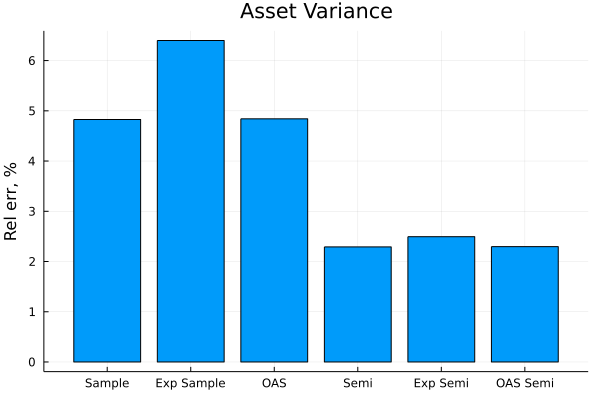

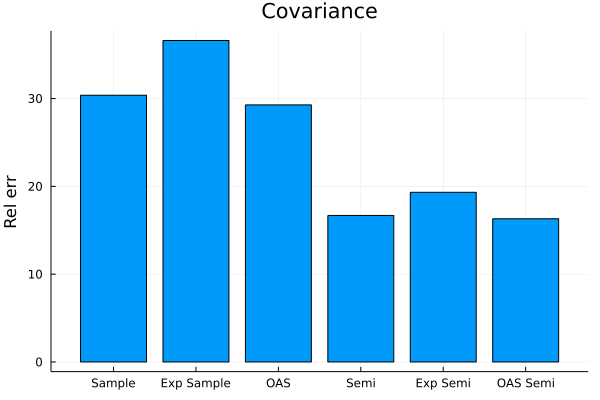

In [6]:
# Number of rows and columns for calculating the exponential weights.
num_rows = nrow(returns)
num_cols = ncol(returns)

# Split the returns into past and future.
past_returns = Matrix(returns[1:div(num_rows, 2), :])
future_returns = Matrix(returns[(div(num_rows, 2)+1):end, :])

# Future covariances.
future_cov = cov(Cov(), future_returns)
future_semi_cov = cov(SCov(), future_returns)

# Sample covariance.
sample_cov = cov(Cov(), past_returns)
# Exponentially weighted covariance.
e_cov = cov(ECov(), past_returns)
# Semicovariance.
semi_cov = cov(SCov(), past_returns)
# Exponentially weighted semicovariance.
e_semi_cov = cov(ESCov(), past_returns)

# Use CovarianceEstimation.jl
target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)
# Shrunken covariance.
oas_shrunken_cov = Matrix(cov(CustomCov(), past_returns, estimator=method))
# Shrunken semicovariance.
oas_shrunken_cov_semi_cov = Matrix(cov(CustomSCov(), past_returns, estimator=method))

# Variance Errors.
future_var = diag(future_cov)
future_semivar = diag(future_semi_cov)

errors = Float64[]
push!(errors, sum(abs.(future_var - diag(sample_cov))))
push!(errors, sum(abs.(future_var - diag(e_cov))))
push!(errors, sum(abs.(future_var - diag(oas_shrunken_cov))))
push!(errors, sum(abs.(future_semivar - diag(semi_cov))))
push!(errors, sum(abs.(future_semivar - diag(e_semi_cov))))
push!(errors, sum(abs.(future_semivar - diag(oas_shrunken_cov_semi_cov))))

errors /= length(future_var)
errors *= 100

fig = bar(
    ["Sample", "Exp Sample", "OAS", "Semi", "Exp Semi", "OAS Semi"],
    errors,
    ylabel="Rel err, %",
    title="Asset Variance",
    legend=false,
)
display(fig)

# Covariance errors.
errors = Float64[]
push!(errors, sum(abs.(future_cov - sample_cov)))
push!(errors, sum(abs.(future_cov - e_cov)))
push!(errors, sum(abs.(future_cov - oas_shrunken_cov)))
push!(errors, sum(abs.(future_semi_cov - semi_cov)))
push!(errors, sum(abs.(future_semi_cov - e_semi_cov)))
push!(errors, sum(abs.(future_semi_cov - oas_shrunken_cov_semi_cov)))

errors /= length(future_var)
errors *= 100

fig = bar(
    ["Sample", "Exp Sample", "OAS", "Semi", "Exp Semi", "OAS Semi"],
    errors,
    ylabel="Rel err",
    legend=false,
    title="Covariance"
)

display(fig)

It's known that semicovariances tend to be more stable than covariances, both graphs are consistent with this idea. The higher temporal stability of downside risk also lends credence to the idea that it is preferable to use optimisers which explicitly account for it, such as `EffSemivar`, `EffCVaR` and `EffCDaR`.

The relationship between each method and its prediction is consistent whether looking at variances or the whole covariance. Obviously, the size of the errors are larger in the latter case, as there are `(I/2 - 1)`, where `I` is the number of items in the diagonal (20 in this case) times more entries in the upper triangle (sans the diagonal) of the covariance matrix. In this case that's 9 times more entries.

If we plot the absolute percentage errors of each entry of the correlation matrices, we can see that the semicovariance is a more stable measure of the correlation between assets, as evidenced by how much darker the second plot is compared to the first.

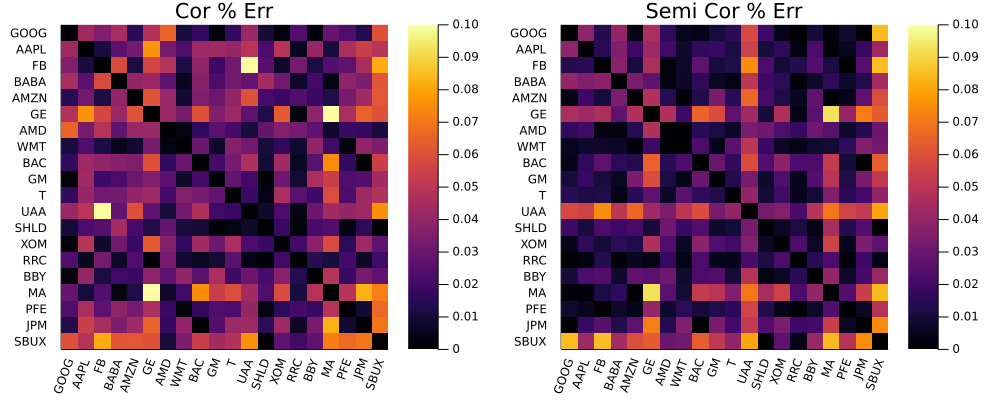

In [7]:
fig1 = heatmap(
    abs.(cov2cor(future_cov) - cov2cor(sample_cov)) / length(future_cov) * 100,
    yflip = true,
    xticks = (1:num_cols, names(returns)),
    yticks = (1:num_cols, names(returns)),
    xrotation = 70,
    clims = (0, 1e-1),
    title = "Cor % Err"
)

fig2 = heatmap(
    abs.(cov2cor(future_semi_cov) - cov2cor(semi_cov)) / length(future_semi_cov) * 100,
    yflip = true,
    xticks = (1:num_cols, names(returns)),
    yticks = (1:num_cols, names(returns)),
    xrotation = 70,
    clims = (0, 1e-1),
    title = "Semi Cor % Err"
)

IJulia.display(plot(fig1, fig2, size = (1000, 400), bottom_margin = 5Plots.mm))

There is a lot of research into why shrunken covariances are preferable to other covariance measures, particularly when the number of samples and observations are in roughly the same scale. The gross oversimplification is that shrunken covariances use a structured estimator to dampen extreme values. This ensures the resulting matrices are postive definite, and produces more stable and robust results because models won't overfit outliers. We can show how different shrunken covariance methods change extreme values.

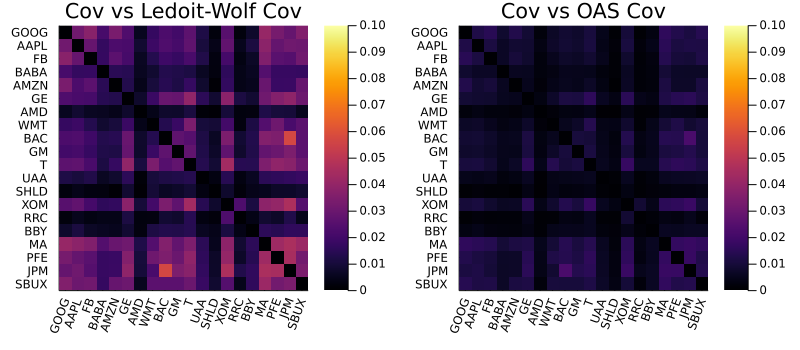

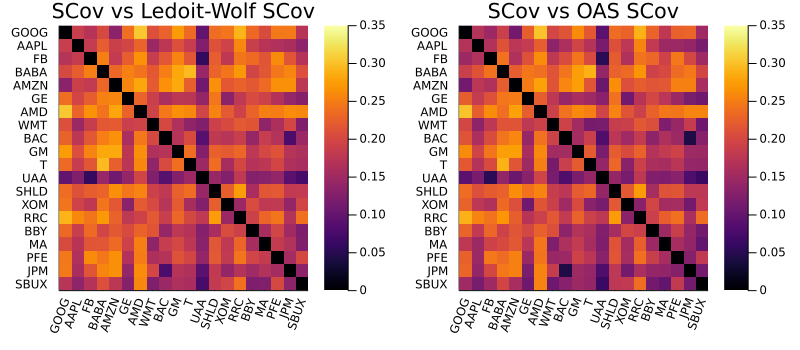

In [8]:
# Covariance
l = @layout [a b]

sample = cov(Cov(), Matrix(returns))

target = DiagonalCommonVariance()
shrinkage = :lw
method = LinearShrinkage(target, shrinkage)
lw_cov = Matrix(cov(CustomCov(), Matrix(returns), estimator=method))

target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)
oas_cov = Matrix(cov(CustomCov(), Matrix(returns), estimator=method))

fig1 = heatmap(
    cov2cor(sample) - cov2cor(lw_cov),
    yflip=true,
    xticks=(1:num_cols, names(returns)),
    yticks=(1:num_cols, names(returns)),
    xrotation=70,
    title="Cov vs Ledoit-Wolf Cov",
    clims=(0, 10e-2)
)

fig2 = heatmap(
    cov2cor(sample) - cov2cor(oas_cov),
    yflip=true,
    xticks=(1:num_cols, names(returns)),
    yticks=(1:num_cols, names(returns)),
    xrotation=70,
    title="Cov vs OAS Cov",
    clims=(0, 10e-2)
)

IJulia.display(plot(fig1, fig2, size=(800, 350), bottom_margin=7Plots.mm, layout=l))

# Semicovariance
l = @layout [a b]

returns = returns_from_prices(hist_prices[!, 2:end])
num_cols = ncol(returns)
num_rows = nrow(returns)

sample = cov(SCov(), Matrix(returns))

target = DiagonalCommonVariance()
shrinkage = :lw
method = LinearShrinkage(target, shrinkage)
lw = cov(CustomSCov(), Matrix(returns), estimator=method)

target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)
oas = cov(CustomSCov(), Matrix(returns), estimator=method)

fig1 = heatmap(
    cov2cor(sample) - cov2cor(lw_cov),
    yflip=true,
    xticks=(1:num_cols, names(returns)),
    yticks=(1:num_cols, names(returns)),
    xrotation=70,
    title="SCov vs Ledoit-Wolf SCov",
    clims=(0, 35e-2)
)

fig2 = heatmap(
    cov2cor(sample) - cov2cor(oas_cov),
    yflip=true,
    xticks=(1:num_cols, names(returns)),
    yticks=(1:num_cols, names(returns)),
    xrotation=70,
    title="SCov vs OAS SCov",
    clims=(0, 35e-2)
)

IJulia.display(plot(fig1, fig2, size=(800, 350), bottom_margin=7Plots.mm, layout=l))

The bright spots are the spots whose values were shrunken the most. Oracle Approximating is a better algorithm when the samples are normally distributed. Returns are not normally distributed, they have large tails over long timespans. However, they are near enough that it tends to do a better job than Ledoit-Wolf. The darker the matrix, the closer it was to the optimal shrinkage. That said, there are many targets and estimators provided by [CovarianceEstimation.jl](https://github.com/mateuszbaran/CovarianceEstimation.jl), and other packages. The composability of Julia means you can plug in whatever estimator that implements the same pattern as for `StatsBase.cov()`.

## Expected returns

We offer a variety of different expected return measures.

- arithmetic mean
- exponentially weighted arithmetic mean
- capital asset pricing model (CAPM)
- exponentially weighted capital asset pricing model

In theory, exponentially weighted returns are more predictive of future returns, as they assign higher weights to more recent values. 

Furthermore, the CAPM is a more stable return measure because it accounts for the return value, covariance to other assets, covariance to the market, and risk free rate. The exponential version simply uses exponential returns to calculate the mean market return.

When you don't provide a vector of market returns to the CAPM returns (which is the case here), they are calculated as the mean of the returns of the assets provided for each observation.

The docs contain additional detail on optional and keyword arguments.

In [9]:
# Split the returns into past and future.
past_returns = Matrix(returns[1:div(num_rows, 2), :])
future_returns = Matrix(returns[(div(num_rows, 2)+1):end, :])

# Arithmetic future returns.
mean_future_rets = ret_model(MRet(), future_returns)

# Various past mean returns.
mean_ret = ret_model(MRet(), past_returns)
e_mean_ret = ret_model(EMRet(), past_returns)#, span = num_rows / 2)
capm_ret = ret_model(CAPMRet(), past_returns)
e_capm_ret = ret_model(ECAPMRet(), past_returns)#, cspan = num_rows / 2, rspan = num_rows / 2)

DataFrame(future = mean_future_rets, mean = mean_ret, emean = e_mean_ret, capm = capm_ret, ecapm = e_capm_ret)

┌ Warning: Covariance matrix is not positive definite. Fixing eigenvalues.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:23
┌ Warning: Covariance matrix could not be fixed. Try a different risk model.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:30
┌ Warning: Covariance matrix is not positive definite. Fixing eigenvalues.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:23
┌ Warning: Covariance matrix could not be fixed. Try a different risk model.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:30


20×5 DataFrame
 Row │ future      mean         emean       capm       ecapm     
     │ Float64     Float64      Float64     Float64    Float64   
─────┼───────────────────────────────────────────────────────────
   1 │  0.251907    0.084095     0.0966601  0.0733891  0.11621
   2 │  0.42774    -0.0192506   -0.113424   0.0775557  0.128924
   3 │  0.235747    0.240336     0.303843   0.0816804  0.136766
   4 │  0.576821   -0.0989912    0.0321639  0.0865019  0.151806
   5 │  0.474416    0.543596     0.649783   0.0862735  0.143421
   6 │ -0.362388    0.125079     0.177431   0.0712196  0.119963
   7 │  0.44086     0.182588     2.23538    0.142432   0.30758
   8 │  0.12899    -0.00619495   0.114549   0.0519984  0.0776635
  ⋮  │     ⋮            ⋮           ⋮           ⋮          ⋮
  14 │ -0.0613527   0.00517498   0.188566   0.071053   0.115011
  15 │ -0.452307   -0.237187     0.366896   0.108906   0.210367
  16 │  0.648166   -0.0427683   -0.0123966  0.083751   0.132949
  17 │  0.433993    0.112071     0.0555051  0.0803037  0.137828
  18 │  0.050772    0.120351     0.175592   0.0586689  0.0917498
  19 │  0.433141    0.0280035    0.0381675  0.0883728  0.16259
  20 │  0.0448829   0.275368     0.146989   0.0732492  0.12166
                                                   5 rows omitted

Note how there are four warnings regarding the covariance matrix not being positive definite. These are from the CAPM returns. As previously mentioned they require a covariance matrix to the market. However, it defaults to the sample covariance.

Just like we did in [Risk Models](#risk-models), we can use more robust estimates of the covariance, by passing `CustomCov()` or `CustomSCov()` via the `cov_type` keyword argument.

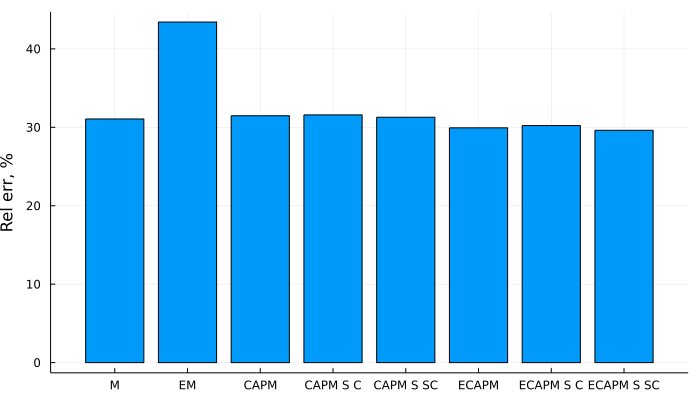

In [10]:
# Covariance estimation parameters. We use Oracle Approximating.
target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

# Different CAPM reutrns with shrunken covariances.
capm_ret_shrunken_cov = ret_model(
    CAPMRet(),
    past_returns,
    cov_type=CustomCov(),
    custom_cov_estimator=method,
)

e_capm_ret_shrunken_cov = ret_model(
    ECAPMRet(),
    past_returns,
    cov_type=CustomCov(),
    custom_cov_estimator=method,
)

capm_ret_shrunken_scov = ret_model(
    CAPMRet(),
    past_returns,
    cov_type=CustomSCov(),
    custom_cov_estimator=method,
)

e_capm_ret_shrunken_scov = ret_model(
    ECAPMRet(),
    past_returns,
    cov_type=CustomSCov(),
    custom_cov_estimator=method,
)

errors = Float64[]
push!(errors, sum(abs.(mean_future_rets - mean_ret)))
push!(errors, sum(abs.(mean_future_rets - e_mean_ret)))
push!(errors, sum(abs.(mean_future_rets - capm_ret)))
push!(errors, sum(abs.(mean_future_rets - capm_ret_shrunken_cov)))
push!(errors, sum(abs.(mean_future_rets - capm_ret_shrunken_scov)))
push!(errors, sum(abs.(mean_future_rets - e_capm_ret)))
push!(errors, sum(abs.(mean_future_rets - e_capm_ret_shrunken_cov)))
push!(errors, sum(abs.(mean_future_rets - e_capm_ret_shrunken_scov)))

errors /= length(mean_future_rets)
errors *= 100

fig = plot(
    ["M", "EM", "CAPM", "CAPM S C", "CAPM S SC", "ECAPM", "ECAPM S C", "ECAPM S SC"],
    errors,
    ylabel="Rel err, %",
    legend=false,
    size=(700, 400),
    seriestype=:bar,
)

display(fig)

Returns are chaotic and unpredictable, so it's often better to optimise portfolios without considering them. In this case, the average absolute errors are all around 30 %. If we were to have a portfolio with a 10 % expected return, it could actually return between [-20, 40] %.

As a result, `min_risk!` portfolios tend to give more stable portfolios. If you really want to use returns, it's better to use some type of CAPM return with a shrunken covariance.

In the following cell, we plot all the return types we've calculated to see how they compare to each other.

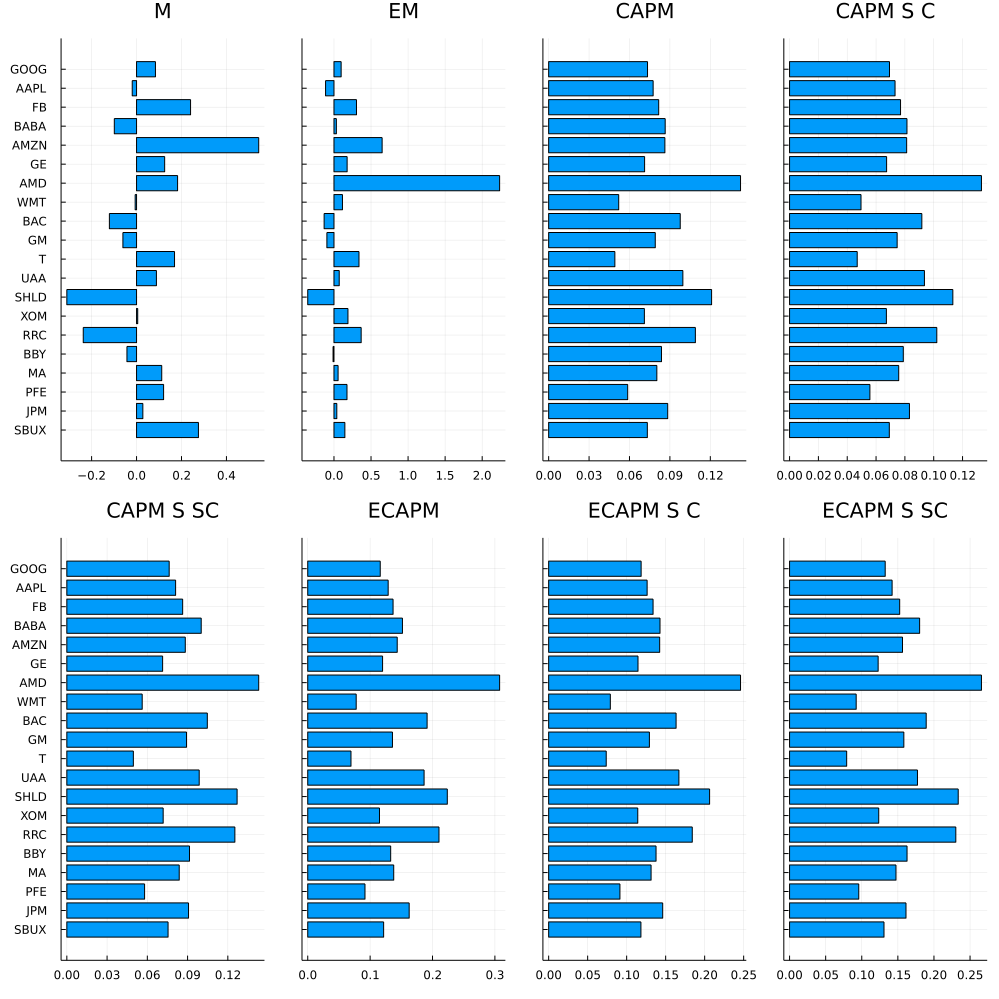

In [11]:
num_cols = ncol(returns)

l = @layout [a b c d; e f g h]

fig1 = bar(
    mean_ret,
    yticks = (1:num_cols, names(returns)),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "M",
)

fig2 = bar(
    e_mean_ret,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "EM",
)

fig3 = bar(
    capm_ret,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "CAPM",
)

fig4 = bar(
    capm_ret_shrunken_cov,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "CAPM S C",
)

fig5 = bar(
    capm_ret_shrunken_scov,
    yticks = (1:num_cols, names(returns)),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "CAPM S SC",
)

fig6 = bar(
    e_capm_ret,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "ECAPM",
)

fig7 = bar(
    e_capm_ret_shrunken_cov,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "ECAPM S C",
)

fig8 = bar(
    e_capm_ret_shrunken_scov,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "ECAPM S SC",
)

plot(fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, layout = l, size = (1000, 1000))

There's strong correspondence between exponential and non-exponentially weighted return types. CAPM returns are a little bit different as they account for an asset's relationship to the market via a covariance matrix, and the risk free rate. So although they seem quite different, they are a better, if more opaque measure.

## Downloading data

In this section we show how we can use [`MarketData.jl`](https://github.com/JuliaQuant/MarketData.jl) to download stock data, [`TimeSeries.jl`](https://github.com/JuliaStats/TimeSeries.jl) to select only the closing prices, and [`DataFrames.jl`](https://dataframes.juliadata.org/stable/) for plotting and other manipulation.

You can acquire lists of stocks from publicly available sources, such as the NASDAQ website, but we'll just provide a list of trendy stocks.

In [12]:
tickers = [
    "ACN",
    "AMZN",
    "COST",
    "DIS",
    "F",
    "GILD",
    "GME",
    "JPM",
    "KO",
    "LUV",
    "MA",
    "MSFT",
    "PFE",
    "TSLA",
    "UNH",
    "XOM",
];


We can download the data from Yahoo using [`MarketData.jl`](https://github.com/JuliaQuant/MarketData.jl).

In [13]:
data = yahoo.(tickers)

16-element Vector{TimeArray{Float64, 2, Date, Matrix{Float64}}}:
 5270×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2001-07-19 to 2022-06-29
 6323×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1997-05-15 to 2022-06-29
 9068×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1986-07-09 to 2022-06-29
 12962×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1971-02-08 to 2022-06-29
 12629×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1972-06-01 to 2022-06-29
 7667×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1992-01-22 to 2022-06-29
 5130×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2002-02-13 to 2022-06-29
 10663×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1980-03-17 to 2022-06-29
 12962×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1971-02-08 to 2022-06-29
 10715×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1980-01-02 to 2022-06-29
 4052×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2006-05-25 to 2022-06-29
 9149×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1986-03-13 to 2022-

We'll use `merge` from [`TimeSeries.jl`](https://github.com/JuliaStats/TimeSeries.jl), rename the columns to match their ticker and put them in a dataframe.

In [14]:
# Merge only on the close data, see the docs for TimeSeries.
hist_prices = merge([data[i][:Close] for i in 1:length(data)]...)
# Convert to a DataFrame.
hist_prices = DataFrames.rename(DataFrame(hist_prices), ["timestamp"; tickers])

3022×17 DataFrame
  Row │ timestamp   ACN      AMZN      COST     DIS      F        GILD     GME ⋯
      │ Date        Float64  Float64   Float64  Float64  Float64  Float64  Flo ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 2010-06-29    38.65    5.4305    55.63    32.3     9.88    17.485    1 ⋯
    2 │ 2010-06-30    38.65    5.463     54.83    31.5    10.08    17.14     1
    3 │ 2010-07-01    38.28    5.548     54.9     31.49   10.57    17.07     1
    4 │ 2010-07-02    37.94    5.457     54.23    31.38   10.28    17.435    1
    5 │ 2010-07-06    38.41    5.503     54.0     31.72   10.16    17.385    1 ⋯
    6 │ 2010-07-07    39.26    5.6715    54.29    33.14   10.59    17.47     1
    7 │ 2010-07-08    39.34    5.811     55.71    33.34   10.62    17.41     1
    8 │ 2010-07-09    39.42    5.863     56.19    33.75   10.85    17.37     1
  ⋮   │     ⋮          ⋮        ⋮         ⋮        ⋮        ⋮        ⋮         ⋱
 3016 │ 2022-06-21   282.73  108.68     463.11    93.29   11.46    60.51    14 ⋯
 3017 │ 2022-06-22   286.4   108.95     459.96    93.5    11.48    61.51    13
 3018 │ 2022-06-23   285.83  112.44     475.0     94.3    11.56    62.58    14
 3019 │ 2022-06-24   299.37  116.46     484.37    97.78   12.01    63.08    13
 3020 │ 2022-06-27   292.62  113.22     481.75    96.61   12.04    62.83    12 ⋯
 3021 │ 2022-06-28   283.8   107.4      468.61    95.92   11.81    62.21    12
 3022 │ 2022-06-29   278.59  108.86     470.23    94.85   11.415   62.59    12
                                                10 columns and 3007 rows omitted

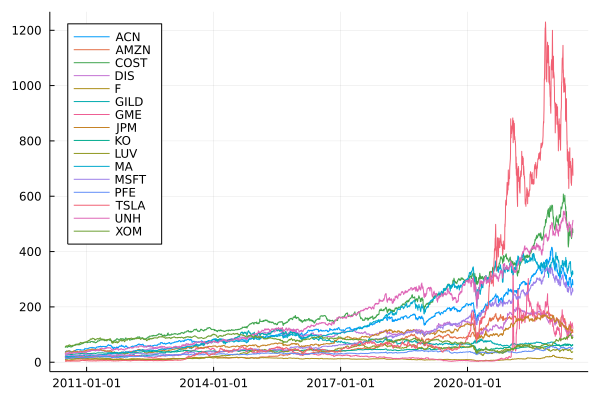

In [15]:
# Plot ticker closing prices.
fig = plot()
for ticker in tickers
    plot!(fig, hist_prices[!, 1], hist_prices[!, ticker], label=ticker)
end
plot(fig, legend=:topleft)

As previously stated, it's best to use a more stable measure of covariance other than the sample covariance matrix. The sample covariance can be subject to noise, particularly if the number of variables is greater than the number of observations. Furthermore, it can be sensitive to extreme outlier observations. We can avoid these by using a more sophisticated estimation of the covariance matrix.

We've been using [CovarianceEstimation.jl](https://github.com/mateuszbaran/CovarianceEstimation.jl) for this tutorial, and I would recommend you use similarly robust estimators for your needs.

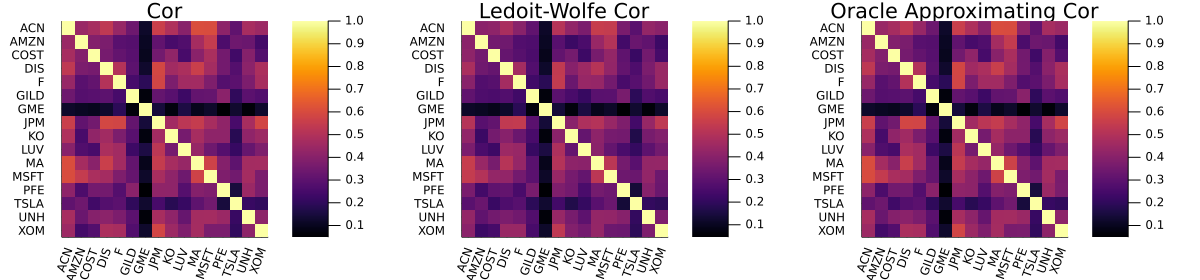

In [16]:
l = @layout [a b c]

returns = returns_from_prices(hist_prices[!, 2:end])
num_cols = ncol(returns)
num_rows = nrow(returns)

S = cov(Cov(), Matrix(returns), freq = 252)

fig1 = heatmap(
    cov2cor(S),
    yflip = true,
    xticks = (1:num_cols, names(returns)),
    yticks = (1:num_cols, names(returns)),
    xrotation = 70,
    title = "Cor"
)

target = DiagonalCommonVariance()
shrinkage = :lw
method = LinearShrinkage(target, shrinkage)

S = cov(CustomCov(), Matrix(returns), estimator=method)

fig2 = heatmap(
    cov2cor(Matrix(S)),
    yflip=true,
    xticks=(1:num_cols, names(returns)),
    yticks=(1:num_cols, names(returns)),
    xrotation=70,
    title = "Ledoit-Wolfe Cor"
)

target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

S = cov(CustomCov(), Matrix(returns), estimator=method)

fig3 = heatmap(
    cov2cor(Matrix(S)),
    yflip=true,
    xticks=(1:num_cols, names(returns)),
    yticks=(1:num_cols, names(returns)),
    xrotation=70,
    title = "Oracle Approximating Cor"
)

IJulia.display(plot(fig1, fig2, fig3, size=(1200, 280), bottom_margin = 5Plots.mm, layout = l))

The `cov` functions defined in `PortfolioOptimiser.jl` also provide a way to use the semicovariance via the `CustomSCov()` struct. As shown in the following cell.

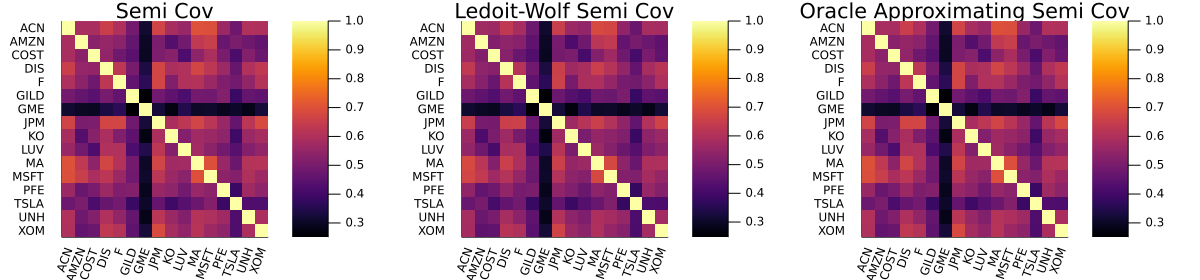

In [17]:
l = @layout [a b c]

returns = returns_from_prices(hist_prices[!, 2:end])
num_cols = ncol(returns)
num_rows = nrow(returns)

S = cov(SCov(), Matrix(returns), freq = 252)

fig1 = heatmap(
    cov2cor(S),
    yflip = true,
    xticks = (1:num_cols, names(returns)),
    yticks = (1:num_cols, names(returns)),
    xrotation = 70,
    title = "Semi Cov"
)

target = DiagonalCommonVariance()
shrinkage = :lw
method = LinearShrinkage(target, shrinkage)

S = cov(CustomSCov(), Matrix(returns), estimator=method)

fig2 = heatmap(
    cov2cor(Matrix(S)),
    yflip=true,
    xticks=(1:num_cols, names(returns)),
    yticks=(1:num_cols, names(returns)),
    xrotation=70,
    title = "Ledoit-Wolf Semi Cov"
)

target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

S = cov(CustomSCov(), Matrix(returns), estimator=method)

fig3 = heatmap(
    cov2cor(Matrix(S)),
    yflip=true,
    xticks=(1:num_cols, names(returns)),
    yticks=(1:num_cols, names(returns)),
    xrotation=70,
    title = "Oracle Approximating Semi Cov"
)

IJulia.display(plot(fig1, fig2, fig3, size=(1200, 280), bottom_margin = 5Plots.mm, layout = l))

# Efficient Frontier Optimisation

As previously stated, providing mean returns is not the best idea given how volatile they can be. Returns are optional on risk minimising portfolios `min_risk!`.

Every optimiser subtyped from `AbstractEfficient` has the following optimisation functions:

- `min_risk!`: minimises the risk measure.
- `max_sharpe!`: maximises `(return - rf)/risk`, where `rf` is the risk free rate. However, it's worth noting this uses a variable transformation to turn the non-convex optimisation problem into a convex one. If you want to use extra objective terms, you should use `custom_nloptimiser!` instead. More on that later.
- `max_utility!`: difference between the `return - l * risk`, where `l` is the risk aversion parameter divided by 2.
- `efficient_return!`: maximises the return with the constraint that the risk must be less than or equal to a specified value.
- `efficient_risk!`: minimises the risk with the constraint that the return must be equal to or greater than a specified value.

Crucially, all concrete `EfficientFrontier` contain a different set of fields given they all require different data. However they all contain a `model` field which stores a `JuMP` model with each optimisation's required `JuMP` variables and constraints. However all models contain a term for the return, `model[:ret]` (if `mean_ret` was provided), and risk, `model[:risk]`, measures. Currently, the only supported portfolio return is the arithmetic return, but this may be expanded in the future to account for other return types such as kelly objectives. The risk measure is dependent on the concrete type of the optimiser. Having a common naming scheme for the return and risk expressions lets users easily use them in their code, for example to build constraints.

As we are demonstrating all optimisation functions, we will provide mean returns. However, we'll use exponentially weighted CAPM returns, with a shrunken covariance. All our covariances (full and semi) will be Oracle Approximating shrunken covariances. This should give us relatively robust measures of returns and risk, reducing the chance to overfit noise.

See what happens when you change the value of `cspan` and `rspan` when calculating `ECAPMRet()` returns, which correspond to the span of the exponential weights applied to the covariance and returns respectively. What happens if you change the value of `span` when calculating `EMRet()`? Try a range of values.

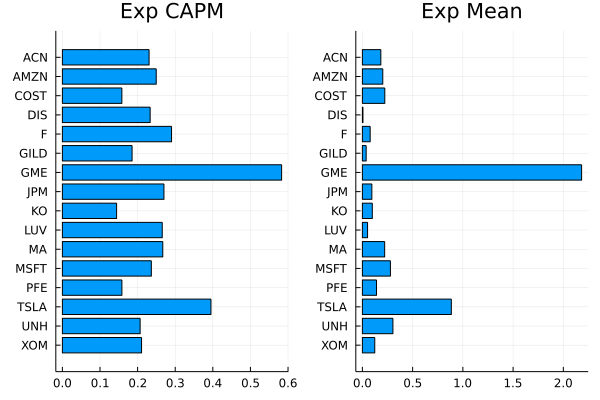

In [18]:
target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

S = cov(CustomCov(), Matrix(returns), estimator = method)

mean_ret = ret_model(
    ECAPMRet(),
    Matrix(returns),
    # cspan = num_rows,
    # rspan = num_rows,
    cov_type = CustomCov(),
    custom_cov_estimator = method,
)

fig1 = bar(
    mean_ret,
    yticks = (1:num_cols, tickers),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "Exp CAPM",
)

fig2 = bar(
    ret_model(
        EMRet(),
        Matrix(returns),
        # span=num_rows,
    ),
    yticks=(1:num_cols, tickers),
    orientation=:h,
    yflip=true,
    legend=false,
    title="Exp Mean",
)

l = @layout [a b]

plot(fig1, fig2, layout = l)

## Mean Variance

These portfolios use the portfolio variance as their risk measure. We'll start off by showing the default behaviour before moving on to more advanced features later.

First, we create our instance of the efficient mean variance structure.

In [19]:
emv = EffMeanVar(tickers, mean_ret, S)

display(fieldnames(typeof(emv)))
methods(EffMeanVar)

(:tickers, :mean_ret, :weights, :cov_mtx, :rf, :market_neutral, :risk_aversion, :target_risk, :target_ret, :extra_vars, :extra_constraints, :extra_obj_terms, :model)

# 2 methods for type constructor:
[1] EffMeanVar(tickers, mean_ret, cov_mtx; weight_bounds, rf, market_neutral, risk_aversion, target_risk, target_ret, extra_vars, extra_constraints, extra_obj_terms) in PortfolioOptimiser at d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\EfficientFrontierOptimiser\MeanVar\MeanVarType.jl:97
[2] EffMeanVar(tickers::T1, mean_ret::T2, weights::T3, cov_mtx::T4, rf::T5, market_neutral::T6, risk_aversion::T7, target_risk::T8, target_ret::T9, extra_vars::T10, extra_constraints::T11, extra_obj_terms::T12, model::T13) where {T1, T2, T3, T4, T5, T6, T7, T8, T9, T10, T11, T12, T13} in PortfolioOptimiser at d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\EfficientFrontierOptimiser\MeanVar\MeanVarType.jl:48

Since use use [`JuMP.jl`](https://jump.dev/JuMP.jl/stable/) we can use all the nice utility afforded by the package.

In [20]:
display(emv.model)
# Portfolio return, dot(w, mean_ret).
display(emv.model[:ret])
# Portfolio risk, in this case this is the portfolio variance dot(w, S, w).
display(emv.model[:risk])
# Model formulation so far.
display(latex_formulation(emv.model))

A JuMP Model
Feasibility problem with:
Variables: 16
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 16 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 16 constraints
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.
Names registered in the model: lower_bounds, ret, risk, sum_w, upper_bounds, w

0.23049441405249305 w[1] + 0.24950038777054923 w[2] + 0.1581672810104472 w[3] + 0.2333471058140885 w[4] + 0.2902546247977428 w[5] + 0.18528251774649288 w[6] + 0.5829145122830769 w[7] + 0.27003552483452525 w[8] + 0.1441614581319663 w[9] + 0.26550400165553917 w[10] + 0.26693321362224304 w[11] + 0.2364946481113086 w[12] + 0.15822929928048793 w[13] + 0.3950099599868296 w[14] + 0.20668095692547347 w[15] + 0.2104885428783184 w[16]

0.058173537061257594 w[1]² + 0.10386004157436705 w[2]² + 0.06851354237044112 w[2]*w[1] + 0.041506239793820274 w[3]² + 0.04622845904355696 w[3]*w[1] + 0.050958183995389206 w[3]*w[2] + 0.06434439918734082 w[4]² + 0.0648738127074437 w[4]*w[1] + 0.060442411378590966 w[4]*w[2] + 0.036964580560326726 w[4]*w[3] + 0.10939964948519736 w[5]² + 0.06927529057009614 w[5]*w[1] + 0.06180736793256671 w[5]*w[2] + 0.0423551190125991 w[5]*w[3] + 0.08433071298464992 w[5]*w[4] + 0.07861494210851779 w[6]² + 0.0454752160939091 w[6]*w[1] + 0.0509581836346111 w[6]*w[2] + 0.03288962123583899 w[6]*w[3] + 0.04231146759078033 w[6]*w[4] + 0.04619908335311179 w[6]*w[5] + 0.9299407638504874 w[7]² + 0.05473194000666336 w[7]*w[1] + 0.06608718636851074 w[7]*w[2] + 0.03829426333379151 w[7]*w[3] + 0.06007741667735965 w[7]*w[4] + 0.12164555136159856 w[7]*w[5] + 0.035895263280478304 w[7]*w[6] + 0.08064638418533754 w[8]² + 0.0764273661887365 w[8]*w[1] + 0.056444206065750555 w[8]*w[2] + 0.04034809290235439 w[8]*w[3] + 0.08426

$$ \begin{aligned}
\text{feasibility}\\
\text{Subject to} \quad & w_{1} + w_{2} + w_{3} + w_{4} + w_{5} + w_{6} + w_{7} + w_{8} + w_{9} + w_{10} + w_{11} + w_{12} + w_{13} + w_{14} + w_{15} + w_{16} = 1.0\\
 & w_{1} \geq 0.0\\
 & w_{2} \geq 0.0\\
 & w_{3} \geq 0.0\\
 & w_{4} \geq 0.0\\
 & w_{5} \geq 0.0\\
 & w_{6} \geq 0.0\\
 & w_{7} \geq 0.0\\
 & w_{8} \geq 0.0\\
 & w_{9} \geq 0.0\\
 & w_{10} \geq 0.0\\
 & w_{11} \geq 0.0\\
 & w_{12} \geq 0.0\\
 & w_{13} \geq 0.0\\
 & w_{14} \geq 0.0\\
 & w_{15} \geq 0.0\\
 & w_{16} \geq 0.0\\
 & w_{1} \leq 1.0\\
 & w_{2} \leq 1.0\\
 & w_{3} \leq 1.0\\
 & w_{4} \leq 1.0\\
 & w_{5} \leq 1.0\\
 & w_{6} \leq 1.0\\
 & w_{7} \leq 1.0\\
 & w_{8} \leq 1.0\\
 & w_{9} \leq 1.0\\
 & w_{10} \leq 1.0\\
 & w_{11} \leq 1.0\\
 & w_{12} \leq 1.0\\
 & w_{13} \leq 1.0\\
 & w_{14} \leq 1.0\\
 & w_{15} \leq 1.0\\
 & w_{16} \leq 1.0\\
\end{aligned} $$

We can use this to finish building the model and optimise for the minimum risk.

In [21]:
min_risk!(emv)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The message that you see when running this comes from Ipopt. It only happens the first time `JuMP.optimize!` is called on a model which has Ipopt as its solver. We chose Ipopt as the default optimiser because aside from mixed-integer optimisation, it can handle all the problem types we have to solve. This means we can provide defaults for all our functions whilst only having two optimisers as dependencies.

The default choice of optimiser can change in the future, but don't worry, you can choose any optimiser that is supported by [`JuMP`](https://jump.dev/JuMP.jl/stable/installation/#Supported-solvers). Bare in mind, some optimisers have no default attributes, so you'll have to use the `optimiser_attributes` keyword argument.

We can see what the model looks like after being solved for minimising risk. If you look closely, the function being minimised is the risk function, which in this case is the portfolio variance `dot(w, S, w)`.

In [22]:
display(latex_formulation(emv.model))
emv.model[:risk]

$$ \begin{aligned}
\min\quad & 0.058173537061257594 w_{1}^2 + 0.10386004157436705 w_{2}^2 + 0.06851354237044112 w_{2}\times w_{1} + 0.041506239793820274 w_{3}^2 + 0.04622845904355696 w_{3}\times w_{1} + 0.050958183995389206 w_{3}\times w_{2} + 0.06434439918734082 w_{4}^2 + 0.0648738127074437 w_{4}\times w_{1} + 0.060442411378590966 w_{4}\times w_{2} + 0.036964580560326726 w_{4}\times w_{3} + 0.10939964948519736 w_{5}^2 + 0.06927529057009614 w_{5}\times w_{1} + 0.06180736793256671 w_{5}\times w_{2} + 0.0423551190125991 w_{5}\times w_{3} + 0.08433071298464992 w_{5}\times w_{4} + 0.07861494210851779 w_{6}^2 + 0.0454752160939091 w_{6}\times w_{1} + 0.0509581836346111 w_{6}\times w_{2} + 0.03288962123583899 w_{6}\times w_{3} + 0.04231146759078033 w_{6}\times w_{4} + 0.04619908335311179 w_{6}\times w_{5} + 0.9299407638504874 w_{7}^2 + 0.05473194000666336 w_{7}\times w_{1} + 0.06608718636851074 w_{7}\times w_{2} + 0.03829426333379151 w_{7}\times w_{3} + 0.06007741667735965 w_{7}\times w_{4} +

0.058173537061257594 w[1]² + 0.10386004157436705 w[2]² + 0.06851354237044112 w[2]*w[1] + 0.041506239793820274 w[3]² + 0.04622845904355696 w[3]*w[1] + 0.050958183995389206 w[3]*w[2] + 0.06434439918734082 w[4]² + 0.0648738127074437 w[4]*w[1] + 0.060442411378590966 w[4]*w[2] + 0.036964580560326726 w[4]*w[3] + 0.10939964948519736 w[5]² + 0.06927529057009614 w[5]*w[1] + 0.06180736793256671 w[5]*w[2] + 0.0423551190125991 w[5]*w[3] + 0.08433071298464992 w[5]*w[4] + 0.07861494210851779 w[6]² + 0.0454752160939091 w[6]*w[1] + 0.0509581836346111 w[6]*w[2] + 0.03288962123583899 w[6]*w[3] + 0.04231146759078033 w[6]*w[4] + 0.04619908335311179 w[6]*w[5] + 0.9299407638504874 w[7]² + 0.05473194000666336 w[7]*w[1] + 0.06608718636851074 w[7]*w[2] + 0.03829426333379151 w[7]*w[3] + 0.06007741667735965 w[7]*w[4] + 0.12164555136159856 w[7]*w[5] + 0.035895263280478304 w[7]*w[6] + 0.08064638418533754 w[8]² + 0.0764273661887365 w[8]*w[1] + 0.056444206065750555 w[8]*w[2] + 0.04034809290235439 w[8]*w[3] + 0.08426

We can check the portfolio performance, and see the weights given to each ticker. As you can see, both `TSLA` and `GME` are quite low, so this optimisation has big 🧻🙌 energy.

In [23]:
mu, sigma, sr = portfolio_performance(emv, verbose=true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 16.58 %
Annual volatility: 14.78 %
Sharpe Ratio: 0.986


16×2 Matrix{Any}:
 "ACN"   1.28354e-6
 "AMZN"  0.0277848
 "COST"  0.235977
 "DIS"   0.0182881
 "F"     6.80234e-7
 "GILD"  0.0693121
 "GME"   0.0063867
 "JPM"   3.85683e-7
 "KO"    0.392683
 "LUV"   0.00544743
 "MA"    3.40515e-7
 "MSFT"  2.44992e-6
 "PFE"   0.166328
 "TSLA"  5.17794e-7
 "UNH"   0.0153393
 "XOM"   0.0624476

Say instead we want to 🚀 go to the moon with our big 💎🙌 energy, and live in a place where mums can't make us clean our rooms, Daddy Elon is world president, and Dogecoin is the biggest, most stable currency ever, trust me bro.

Well we can do just that and ensure we put at least 30% of our assets into GME and TSLA each. Daddy Bezos can get a bone cause the chad went to space, so we'll give him at least 23% and at most 69%. Daddy Gates needs to chill with all his "world is unprepared for its next pandemic" shenanigans, so we'll make sure he gets 4.20% at best.

In [24]:
weight_bounds = fill((0.0, 1.0), length(tickers))

tsla_idx = findfirst(x -> x == "TSLA", tickers)
gme_idx = findfirst(x -> x == "GME", tickers)
amzn_idx = findfirst(x -> x == "AMZN", tickers)
msft_idx = findfirst(x -> x == "MSFT", tickers)

# Daddy Elon and GME get big 💎🙌 energy.
weight_bounds[[tsla_idx; gme_idx]] .= [(0.3, 1), (0.3, 1)]
# Daddy Bezos gets a bone.
weight_bounds[amzn_idx] = (0.23, 0.69)
# Daddy Gates gotta chill.
weight_bounds[msft_idx] = (0, 420e-4)

[tickers weight_bounds]

16×2 Matrix{Any}:
 "ACN"   (0.0, 1.0)
 "AMZN"  (0.23, 0.69)
 "COST"  (0.0, 1.0)
 "DIS"   (0.0, 1.0)
 "F"     (0.0, 1.0)
 "GILD"  (0.0, 1.0)
 "GME"   (0.3, 1.0)
 "JPM"   (0.0, 1.0)
 "KO"    (0.0, 1.0)
 "LUV"   (0.0, 1.0)
 "MA"    (0.0, 1.0)
 "MSFT"  (0.0, 0.042)
 "PFE"   (0.0, 1.0)
 "TSLA"  (0.3, 1.0)
 "UNH"   (0.0, 1.0)
 "XOM"   (0.0, 1.0)

We can create our 💎🙌 instance of a mean variance portfolio and check that the weight bounds have been properly set up.

In [25]:
diamond_hands = EffMeanVar(tickers, mean_ret, S, weight_bounds = weight_bounds)
latex_formulation(diamond_hands.model)

$$ \begin{aligned}
\text{feasibility}\\
\text{Subject to} \quad & w_{1} + w_{2} + w_{3} + w_{4} + w_{5} + w_{6} + w_{7} + w_{8} + w_{9} + w_{10} + w_{11} + w_{12} + w_{13} + w_{14} + w_{15} + w_{16} = 1.0\\
 & w_{1} \geq 0.0\\
 & w_{2} \geq 0.23\\
 & w_{3} \geq 0.0\\
 & w_{4} \geq 0.0\\
 & w_{5} \geq 0.0\\
 & w_{6} \geq 0.0\\
 & w_{7} \geq 0.3\\
 & w_{8} \geq 0.0\\
 & w_{9} \geq 0.0\\
 & w_{10} \geq 0.0\\
 & w_{11} \geq 0.0\\
 & w_{12} \geq 0.0\\
 & w_{13} \geq 0.0\\
 & w_{14} \geq 0.3\\
 & w_{15} \geq 0.0\\
 & w_{16} \geq 0.0\\
 & w_{1} \leq 1.0\\
 & w_{2} \leq 0.69\\
 & w_{3} \leq 1.0\\
 & w_{4} \leq 1.0\\
 & w_{5} \leq 1.0\\
 & w_{6} \leq 1.0\\
 & w_{7} \leq 1.0\\
 & w_{8} \leq 1.0\\
 & w_{9} \leq 1.0\\
 & w_{10} \leq 1.0\\
 & w_{11} \leq 1.0\\
 & w_{12} \leq 0.042\\
 & w_{13} \leq 1.0\\
 & w_{14} \leq 1.0\\
 & w_{15} \leq 1.0\\
 & w_{16} \leq 1.0\\
\end{aligned} $$

And we optimise babbyyyyyy!

In [26]:
min_risk!(diamond_hands)
diamond_mu, diamond_sigma, diamond_sr = portfolio_performance(diamond_hands, verbose=true)
[tickers diamond_hands.weights]

LOCALLY_SOLVED
Expected annual return: 37.6 %
Annual volatility: 38.59 %
Sharpe Ratio: 0.922


16×2 Matrix{Any}:
 "ACN"   7.07278e-8
 "AMZN"  0.23
 "COST"  2.16772e-7
 "DIS"   7.53641e-8
 "F"     3.34255e-8
 "GILD"  1.7238e-7
 "GME"   0.3
 "JPM"   6.14235e-8
 "KO"    0.11905
 "LUV"   5.07283e-8
 "MA"    5.42297e-8
 "MSFT"  5.01794e-8
 "PFE"   0.0509493
 "TSLA"  0.3
 "UNH"   1.73475e-7
 "XOM"   1.34012e-7

We are so going to the 🚀 moon, dude 💎🙌. Ignore the fact that the optimiser decided to lowball our low bounds, the package was made by a ligma grindset 🧻🙌 🤮🤮.

Lets try other objectives, without our restrictions. Gotta keep the 🧻🙌 happy.

In [27]:
emv = EffMeanVar(tickers, mean_ret, S);

We optimise for the minimum risk.

In [28]:
min_risk!(emv)
mu_risk, sigma_risk, sr_risk = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 16.58 %
Annual volatility: 14.78 %
Sharpe Ratio: 0.986


16×2 Matrix{Any}:
 "ACN"   1.28354e-6
 "AMZN"  0.0277848
 "COST"  0.235977
 "DIS"   0.0182881
 "F"     6.80234e-7
 "GILD"  0.0693121
 "GME"   0.0063867
 "JPM"   3.85683e-7
 "KO"    0.392683
 "LUV"   0.00544743
 "MA"    3.40515e-7
 "MSFT"  2.44992e-6
 "PFE"   0.166328
 "TSLA"  5.17794e-7
 "UNH"   0.0153393
 "XOM"   0.0624476

Next we'll maximise the utility, we'll use the default value of risk aversion which is 1.

In [29]:
max_utility!(emv)
mu_util1, sigma_util1, sr_util1 = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 43.08 %
Annual volatility: 45.31 %
Sharpe Ratio: 0.907


16×2 Matrix{Any}:
 "ACN"   7.11905e-8
 "AMZN"  1.09662e-7
 "COST"  1.7719e-8
 "DIS"   7.51768e-8
 "F"     0.146258
 "GILD"  2.83473e-8
 "GME"   0.340567
 "JPM"   0.0576935
 "KO"    1.54415e-8
 "LUV"   4.46943e-7
 "MA"    0.0444051
 "MSFT"  7.81723e-8
 "PFE"   1.99857e-8
 "TSLA"  0.411075
 "UNH"   4.569e-8
 "XOM"   4.35588e-8

If we increase the risk aversion we'll get lower risk scores, but potentially lower returns too.

In [30]:
max_utility!(emv, 5)
mu_util1, sigma_util1, sr_util1 = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 28.17 %
Annual volatility: 21.42 %
Sharpe Ratio: 1.222


16×2 Matrix{Any}:
 "ACN"   0.0757676
 "AMZN"  0.069957
 "COST"  0.00240929
 "DIS"   0.0605327
 "F"     0.0821482
 "GILD"  0.0579969
 "GME"   0.0786087
 "JPM"   0.101594
 "KO"    2.21585e-7
 "LUV"   0.0712162
 "MA"    0.101136
 "MSFT"  0.075762
 "PFE"   0.0239696
 "TSLA"  0.0826336
 "UNH"   0.0684944
 "XOM"   0.0477735

At the limit of `0` and `Inf` risk aversion, we recover the maximum return and minimum volatility portfolios.

Lets try to recover the minimum volatility portfolio first.

In [31]:
max_utility!(emv, 1e12)
mu_utilInf, sigma_utilInf, sr_utilInf = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 16.58 %
Annual volatility: 14.78 %
Sharpe Ratio: 0.986


16×2 Matrix{Any}:
 "ACN"   -1.0e-8
 "AMZN"   0.0277862
 "COST"   0.235978
 "DIS"    0.0182902
 "F"     -1.0e-8
 "GILD"   0.0693125
 "GME"    0.00638674
 "JPM"   -1.0e-8
 "KO"     0.392686
 "LUV"    0.00544236
 "MA"    -1.0e-8
 "MSFT"  -1.0e-8
 "PFE"    0.166329
 "TSLA"  -1.0e-8
 "UNH"    0.015339
 "XOM"    0.0624495

In [32]:
all(isapprox.([mu_utilInf, sigma_utilInf, sr_utilInf], [mu_risk, sigma_risk, sr_risk], atol = 1e-5))

true

Lets try the maximum return portfolio next.

In [33]:
max_utility!(emv, 1e-12)
mu_util0, sigma_util0, sr_util0 = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 58.29 %
Annual volatility: 96.43 %
Sharpe Ratio: 0.584


16×2 Matrix{Any}:
 "ACN"   -1.25456e-9
 "AMZN"  -6.47977e-10
 "COST"  -2.99086e-9
 "DIS"   -1.16849e-9
 "F"      9.72629e-10
 "GILD"  -2.42668e-9
 "GME"    1.0
 "JPM"    1.06532e-10
 "KO"    -3.2506e-9
 "LUV"   -6.99007e-11
 "MA"    -1.48988e-11
 "MSFT"  -1.07156e-9
 "PFE"   -2.98966e-9
 "TSLA"   8.53436e-9
 "UNH"   -1.91334e-9
 "XOM"   -1.81467e-9

There is no function that exposes the user to optimising for the maximum return without constraints. 🧻🙌 say it's a bad idea, but as a chad 💎🙌 we can work around it if we're REDACTED enough. There is even an internally defined subroutine that stops the user from finagling an unconstrained optimisation for maximising the return. 

In order to prove our point, we can trigger the warning and subsequent adjustment in the `efficient_return!` function by providing an unfeasable target return. You can see the warning with the value two cells down.

Clearly, GME is the true 💎🙌 choice.

In [34]:
mu_util0 ≈ 0.5632840778712173

false

We can optimise for the lowest risk for a given target return. However, if we give a target return that is too large, the optimiser adjusts it to half of the maximum possible return. 

Portfolios optimimised by this subroutine will have a calculated return that is greater than or equal to the target.

In [35]:
efficient_return!(emv, mu_risk * 10)
mu_ret, sigma_ret, sr_ret = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 29.15 %
Annual volatility: 22.36 %
Sharpe Ratio: 1.214


┌ Warning: Value of target_ret, 1.6577924816532283 > 0.582914518153053. Correcting to 0.2914572590765265.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\BaseOptimiser\BaseOptimiserUtil.jl:394


16×2 Matrix{Any}:
 "ACN"   0.0706269
 "AMZN"  0.0714933
 "COST"  9.89084e-7
 "DIS"   0.0523018
 "F"     0.0909815
 "GILD"  0.0483053
 "GME"   0.0868129
 "JPM"   0.123756
 "KO"    5.32941e-7
 "LUV"   0.0738245
 "MA"    0.120192
 "MSFT"  0.0738081
 "PFE"   1.20738e-5
 "TSLA"  0.0937739
 "UNH"   0.0622216
 "XOM"   0.0318888

We can also optimise for the greatest return given a target risk. If the target risk is lower than the minimum possible risk, it will warn the user and adjust the target to the minimum possible, given the covariance matrix. However, the solution may be infeasable despite this. Different solvers have different behaviours regarding infeasability. Luckily, Ipopt solves the problem as best it can. In this case, it means the lowest value of risk that makes solving feasable. However, this may not always be the case, especially if there are extra constraints, the objective has extra terms, or is a `JuMP.@NLobjective`.

In [36]:
efficient_risk!(emv, sigma_risk / 10)
mu_erisk, sigma_erisk, sr_erisk = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_INFEASIBLE
Expected annual return: 16.58 %
Annual volatility: 14.78 %
Sharpe Ratio: 0.986


┌ Warning: Value of min_volatility, 0.014784554405694945 < 0.14608706978279754. Correcting to 0.14608706978279754.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\BaseOptimiser\BaseOptimiserUtil.jl:394
┌ Warning: The optimiser could not solve the problem satisfactorily: LOCALLY_INFEASIBLE. The solution may be useful regardless.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\BaseOptimiser\BaseOptimiserUtil.jl:418


16×2 Matrix{Any}:
 "ACN"   -8.71753e-9
 "AMZN"   0.0277862
 "COST"   0.235978
 "DIS"    0.0182902
 "F"     -9.31362e-9
 "GILD"   0.0693125
 "GME"    0.00638674
 "JPM"   -9.60446e-9
 "KO"     0.392686
 "LUV"    0.00544236
 "MA"    -9.64955e-9
 "MSFT"  -7.80527e-9
 "PFE"    0.166329
 "TSLA"  -9.48136e-9
 "UNH"    0.015339
 "XOM"    0.0624495

In [37]:
all(isapprox.([mu_erisk, sigma_erisk, sr_erisk], [mu_risk, sigma_risk, sr_risk], atol = 1e-5))

true

If we are 🤘🤙 trve kvlt 💎🙌, then we don't mess around with low-risk, low-T BS 💩... we go all in, sweetheart 😎😎😎.

In [38]:
efficient_risk!(emv, sigma_risk * 666)
mu_erisk, sigma_erisk, sr_erisk = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 58.29 %
Annual volatility: 96.43 %
Sharpe Ratio: 0.584


16×2 Matrix{Any}:
 "ACN"   -1.24874e-9
 "AMZN"  -6.7914e-10
 "COST"  -2.90123e-9
 "DIS"   -1.16771e-9
 "F"      8.31095e-10
 "GILD"  -2.36017e-9
 "GME"    1.0
 "JPM"    2.54851e-11
 "KO"    -3.15182e-9
 "LUV"   -1.38974e-10
 "MA"    -8.76874e-11
 "MSFT"  -1.07655e-9
 "PFE"   -2.90008e-9
 "TSLA"   8.50508e-9
 "UNH"   -1.87145e-9
 "XOM"   -1.77788e-9

Once again, we see GME is for chad kings 🤴 and chadette queens 👸, baby. And we get the same result as when we dropped our risk aversion close to zero in `max_utility!`.

There is an extra function, `max_sharpe!`, which maximises the ratio between return and risk, for a given risk free rate. We're using `ECAPM()` returns, so we've already accounted for the risk free rate. So we'll make it zero in the instance, we can also provide it in the function itself after the `EffMeanVar` variable.

A thing to note about optimising for the Sharpe ratio is that it requires a fresh instance of the optimiser structure. This is because it uses a variable transformation to turn the nonconvex problem into a convex one. It is also worth noting that after optimising for the Sharpe ratio, you should not use the same optimiser structure to perform other optimisations in series like we've done so far. The extra constraints and variable transformation will mess with the optimisations.

In [39]:
emv = EffMeanVar(tickers, mean_ret, S, rf = eps());
max_sharpe!(emv)
mu_sharpe, sigma_sharpe, sr_sharpe = portfolio_performance(emv, verbose=true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 24.29 %
Annual volatility: 18.15 %
Sharpe Ratio: 1.338


16×2 Matrix{Any}:
 "ACN"   0.0549697
 "AMZN"  0.0598342
 "COST"  0.0846683
 "DIS"   0.0616391
 "F"     0.0537738
 "GILD"  0.0637241
 "GME"   0.055474
 "JPM"   0.045575
 "KO"    0.105559
 "LUV"   0.0579771
 "MA"    0.0449184
 "MSFT"  0.0561617
 "PFE"   0.0764578
 "TSLA"  0.053874
 "UNH"   0.0588429
 "XOM"   0.0665512

The variable transformation also means that extra objective functions and non-convex constraints may not work as expected. For this, it's better to use `custom_nloptimiser!`. First we have to define the nonlinear function we'll be optimising, and adding any extra objective terms we want to the definition. If you want to maximise a quantity, make it negative, `custom_nloptimiser!` minimises the function it is given.

The function has to be defined with the non-argument (ie non `JuMP` variables) parameters as an array called `obj_params` inside the function definition. This is because that's the variable name known to `custom_nloptimiser!`. 

Nonlinear optimisation functions should accept scalar values only, as that is a quirk of `JuMP`'s nonlinear modelling framework. Also, when using functions defined by `PortfolioOptimiser.jl`, you have to annotate them as such inside the function. When calling user defined functions inside the optimisation function, you don't need to qualify them with any prefix.

In [40]:
function sharpe_ratio_nl(w::T...) where {T}
    mean_ret = obj_params[1]
    cov_mtx = obj_params[2]
    rf = obj_params[3]
    γ = obj_params[4]

    w = [i for i in w]
    sr = PortfolioOptimiser.sharpe_ratio(w, mean_ret, cov_mtx, rf)

    return -sr + PortfolioOptimiser.L2_reg(w, γ)
end

sharpe_ratio_nl (generic function with 1 method)

As γ grows, the weights should become more uniform and there should be fewer small weights, this is the case when looking at the weights calculated using the nonlinear optimiser with the added L2 regularisation.

In [41]:
nl_ef = EffMeanVar(tickers, mean_ret, S, rf=eps())
# These correspond to obj_params in the definition of sharpe_ratio_nl. 
obj_params = [nl_ef.mean_ret, nl_ef.cov_mtx, nl_ef.rf, 0]
# This should give an answer close to the max_sharpe! optimisation as γ is zero.
custom_nloptimiser!(nl_ef, sharpe_ratio_nl, obj_params)
nl_mu0, nl_sigma0, nl_sr0 = portfolio_performance(nl_ef, verbose=true)
[tickers nl_ef.weights]

LOCALLY_SOLVED
Expected annual return: 24.29 %
Annual volatility: 18.15 %
Sharpe Ratio: 1.338


16×2 Matrix{Any}:
 "ACN"   0.0549697
 "AMZN"  0.0598342
 "COST"  0.0846683
 "DIS"   0.0616391
 "F"     0.0537738
 "GILD"  0.0637241
 "GME"   0.055474
 "JPM"   0.045575
 "KO"    0.105559
 "LUV"   0.0579771
 "MA"    0.0449184
 "MSFT"  0.0561617
 "PFE"   0.0764578
 "TSLA"  0.053874
 "UNH"   0.0588429
 "XOM"   0.0665512

Typically, the nonlinear optimiser does a better job of optimising than using the variable transformatioin, but the results are generally quite similar, as you can see the sharpe ratio of the given by the portfolio optimised with the nonlinear optimiser is larger.

In [42]:
[nl_sr0 sr_sharpe]

1×2 Matrix{Float64}:
 1.33836  1.33836

The reason our previous optimisations yielded very similar weights for all assets is because we are using robust measures of covariance and returns, both of which ensure the optimisers do not overfit extreme fluctuations. Leading to portfolios that are more resilient to extreme fluctuations.

We'll use normal mean returns to illustrate the how asset weights should get more uniform as γ increases in value. As mentione previously, this only really works when using the nonlinear optimiser because the variable transformation used in `max_sharpe!` cannot account for extra objective terms. So when you need something like this, you should use the nonlinear option and add them to the definition of the nonlinear objective function.

In [43]:
mean_ret = ret_model(MRet(), Matrix(returns))
S = cov(CustomCov(), Matrix(returns), estimator=method)

nl_ef = EffMeanVar(tickers, mean_ret, S, rf=eps())
obj_params = [nl_ef.mean_ret, nl_ef.cov_mtx, nl_ef.rf, 0]
custom_nloptimiser!(nl_ef, sharpe_ratio_nl, obj_params)
# nl_mu0, nl_sigma0, nl_sr0 = portfolio_performance(nl_ef, verbose=true)
nl_weights0 = nl_ef.weights

nl_ef = EffMeanVar(tickers, mean_ret, S, rf=eps())
obj_params = [nl_ef.mean_ret, nl_ef.cov_mtx, nl_ef.rf, 2]
custom_nloptimiser!(nl_ef, sharpe_ratio_nl, obj_params)
# nl_mu2, nl_sigma2, nl_sr2 = portfolio_performance(nl_ef, verbose=true)
nl_weights2 = nl_ef.weights

nl_ef = EffMeanVar(tickers, mean_ret, S, rf=eps())
obj_params = [nl_ef.mean_ret, nl_ef.cov_mtx, nl_ef.rf, 4]
custom_nloptimiser!(nl_ef, sharpe_ratio_nl, obj_params)
# nl_mu4, nl_sigma4, nl_sr4 = portfolio_performance(nl_ef, verbose=true)
nl_weights4 = nl_ef.weights

nl_ef = EffMeanVar(tickers, mean_ret, S, rf=eps())
obj_params = [nl_ef.mean_ret, nl_ef.cov_mtx, nl_ef.rf, 16]
custom_nloptimiser!(nl_ef, sharpe_ratio_nl, obj_params)
# nl_mu16, nl_sigma16, nl_sr16 = portfolio_performance(nl_ef, verbose=true)
nl_weights16 = nl_ef.weights

[nl_weights0 nl_weights2 nl_weights4 nl_weights16]

16×4 Matrix{Float64}:
 -9.93455e-9   0.0601888    0.0677087   0.065796
  0.114985     0.114105     0.102883    0.0787167
  0.302456     0.149248     0.117291    0.0784441
 -9.97846e-9  -9.7935e-9    0.0249394   0.0523624
 -9.99036e-9  -9.98408e-9  -9.97328e-9  0.0326611
 -9.9464e-9    0.0413291    0.0546741   0.0612583
 -9.82069e-9   0.0109707    0.0169735   0.0363078
 -9.98203e-9  -9.92946e-9   0.0134886   0.0487136
 -9.94915e-9   0.0567113    0.0632694   0.0621096
 -9.97568e-9  -4.11371e-9   0.0249936   0.0506188
  0.091007     0.106034     0.0937169   0.0736088
 -9.82096e-9   0.0831171    0.0829548   0.0714059
 -9.897e-9     0.0747336    0.0742788   0.0659828
  0.13532      0.12759      0.118904    0.0910081
  0.356232     0.175971     0.134428    0.0841659
 -9.98318e-9  -9.94348e-9   0.0094962   0.0468401

Note how the rows get more uniform and have fewer negligible weights as we move right along the matrix.

When we do the same for the `max_sharpe!` subroutine, we get completely different and incorrect behaviour. In this case, we add the extra term as part of the definition of the instance. These have to be as quoted values, because of the way `JuMP` operates. Internally, model variables are known as `model[<key>]`. The variable `model` is going to be known internally, using anything else will result in an error.

Furthermore, any `JuMP` variable referenced in `extra_constraints` or `extra_obj_terms` must be registered in the model. If it's a variable created by the constructor (as is the case for `model[:w]`, it will be known by the time it gets added to the objective function. However, if it's an extra variable not natively known to the optimisation at hand, it can be passed to the constructor via the `extra_vars` keyword as a collection of symbols or expressions, even if it's a single variable, ie `extra_vars = [:(m[1:10] >= 2)]`. The constructor will add the extra variables to the model before they are used to generate extra constraints or added to the objective. Extra constraints can be passed as a collection of expressions not quotes or symbols, even if it's a single extra constraint via the `extra_constraints` keyword. Extra objective terms have to be passed as a collection of quotes, not expressions or symbols via the `extra_obj_terms` keyword function. We can use functions for the `extra_obj_terms` as long as they have been defined either by the user or `PortoflioOptimiser` before we call the constructor.

Extra variables, constraints, and objective terms will be added to the model as long as they conform to the relevant `JuMP` syntax and requirements.

In [44]:
ef = EffMeanVar(tickers, mean_ret, S, rf = eps(), extra_obj_terms = [quote
    L2_reg(model[:w], 0)
end])
max_sharpe!(ef)
# mu0, sigma0, sr0 = portfolio_performance(ef, verbose = true)
weights0 = ef.weights

ef = EffMeanVar(tickers, mean_ret, S, rf = eps(), extra_obj_terms = [quote
    L2_reg(model[:w], 2)
end])
max_sharpe!(ef)
# mu2, sigma2, sr2 = portfolio_performance(ef, verbose = true)
weights2 = ef.weights

ef = EffMeanVar(tickers, mean_ret, S, rf = eps(), extra_obj_terms = [quote
    L2_reg(model[:w], 4)
end])
max_sharpe!(ef)
# mu4, sigma4, sr4 = portfolio_performance(ef, verbose = true)
weights4 = ef.weights

ef = EffMeanVar(tickers, mean_ret, S, rf = eps(), extra_obj_terms = [quote
    L2_reg(model[:w], 16)
end])
max_sharpe!(ef)
# mu16, sigma16, sr16 = portfolio_performance(ef, verbose = true)
weights16 = ef.weights

[weights0 weights2 weights4 weights16]

┌ Warning: Sharpe ratio optimisation uses a variable transformation which means extra objective terms may not behave as expected. Use custom_nloptimiser if extra objective terms are needed.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\EfficientFrontierOptimiser\MeanVar\MeanVarFunc.jl:145
┌ Warning: Sharpe ratio optimisation uses a variable transformation which means extra objective terms may not behave as expected. Use custom_nloptimiser if extra objective terms are needed.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\EfficientFrontierOptimiser\MeanVar\MeanVarFunc.jl:145
┌ Warning: Sharpe ratio optimisation uses a variable transformation which means extra objective terms may not behave as expected. Use custom_nloptimiser if extra objective terms are needed.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\EfficientFrontierOptimiser\MeanVar\MeanVarFunc.jl:145
┌ Warning: Sharpe ratio optimisation uses a variable

16×4 Matrix{Float64}:
 1.89861e-8   0.0669659    0.0663365   0.0655762
 0.114985     0.111381     0.107883    0.104705
 0.302456     0.0799644    0.0757604   0.0722524
 4.36076e-9   0.0281347    0.0312538   0.0335172
 3.95539e-10  9.43437e-10  1.92465e-9  0.00212429
 1.50367e-8   0.0399106    0.0405389   0.0408357
 2.0291e-7    0.0438586    0.051422    0.0590091
 3.16923e-9   0.0286726    0.0324083   0.0351707
 1.41233e-8   0.0281708    0.0286088   0.0288207
 5.28699e-9   0.0312282    0.034385    0.0367688
 0.091007     0.101312     0.0982201   0.0954587
 5.68198e-8   0.0856032    0.0836971   0.0818659
 3.149e-8     0.0446795    0.0437983   0.0429349
 0.13532      0.192968     0.190339    0.187425
 0.356232     0.112667     0.106363    0.101124
 2.78803e-9   0.00448298   0.00898575  0.0124122

We can see that the L2 regularisation is not working properly on `max_sharpe!`. We can show that it works for `custom_nloptimiser!` by finding the variance of each set of weights. It should tend towards zero with quadratic convergence. In other words, each doubling of γ should roughly half the variance in weights. This is almost exactly what happens with `custom_nloptimiser!`, `max_sharpe!` is doing something else entirely. The convergence will not be exactly quadratic, as the covariance matrix plays a large part in the optimisation.

It's clear the variance in weights obtained using the nonlinear optimiser half with every doubling of γ. The third row is roughly half of the second row, the fourth row is almost 8 times (almost cubic convergence) smaller than the third. This is not the case for the weights obtained via the `max_sharpe!` optimisation.

If you go back and use different return and covariance matrix models, these numbers will change. The quadratic convergence may be obfuscated by them, but such is the nature of asymptotics.

In [45]:
# Variance of the weights yielded with the max sharpe optimisation with L2 regularisation with the nonlinear optimisation.
display(var([nl_weights0 nl_weights2 nl_weights4 nl_weights16], dims = 1))

# Variance of the weights yielded with the max sharpe optimisation with L2 regularisation with the convex optimisation.
display(var([weights0 weights2 weights4 weights16], dims = 1))

1×4 Matrix{Float64}:
 0.0130464  0.00349629  0.00190777  0.00028549

1×4 Matrix{Float64}:
 0.0130464  0.00248149  0.00225253  0.00205645

## Mean Semivariance

There are two ways of getting a mean semivariance optimisation in `PortfolioOptimiser.jl`:

1. Use `EffMeanVar` with a semicovariance.
2. Use `EffMeanSemivar`.

The first isn't truly optimal, but if performance is an issue, then it's not a bad option. However, Julia's fast so the performance will be limited to the optimiser being used.

We'll show both methods on the data we used in [Mean Variance](#mean-variance).

All functions involving semivariances, use the daily risk free rate, `1.02^(1/252)-1`, as the default value for discerning downside from upside risk. Any returns below it are classified as downside. The rationale for this is that at that point you might as well get US treasury bonds as a safe investment. However, you can decide what value you'd like to use with the `target` keyword argument on any function that uses/calculates the semivariance.

In [46]:
target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

# Shrunken semicov, downside risk is anything below 0 returns.
S = cov(CustomSCov(), Matrix(returns), estimator = method)

# Exponential CAPM returns with shrunken semicov, downside risk is anything below 0 returns.
mean_ret = ret_model(
    ECAPMRet(),
    Matrix(returns),
    cov_type = CustomSCov(),
    custom_cov_estimator = method,
);

We can show how the mean variance with the semicovariance is never as optimal as using meansemivariance optimisations.

In [47]:
emv = EffMeanVar(tickers, mean_ret, S)
emsv = EffMeanSemivar(tickers, mean_ret, Matrix(returns));

Minimise risk.

In [48]:
min_risk!(emv)
min_risk!(emsv)

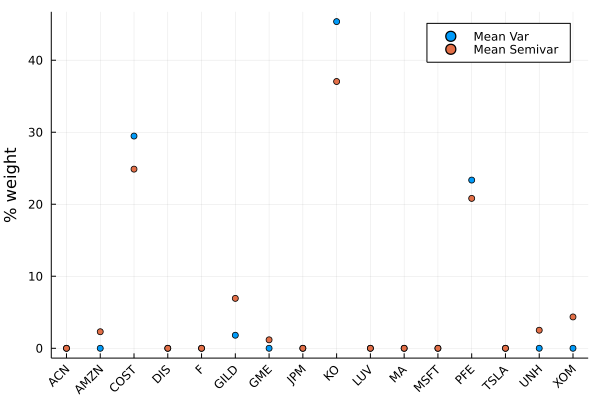

In [49]:
fig = plot()
scatter!(fig, 1:length(emv.tickers), emv.weights*100, label = "Mean Var")
scatter!(fig, 1:length(emv.tickers), emsv.weights*100, label = "Mean Semivar")
plot(fig, ylabel="% weight", xticks=(1:length(emv.tickers), emv.tickers), xrotation=45)

We can check the risk, ie semideviation, to see which is lower.

In [50]:
println("Mean variance with semicovariance.")
mu1, sigma1, sr1 = portfolio_performance(emv, verbose=true)
println((mu1, sigma1, sr1))

println("\nMean semivariance optimisation.")
mu2, sigma2, sr2 = portfolio_performance(emsv, verbose=true)
println((mu2, sigma2, sr2))

Mean variance with semicovariance.
LOCALLY_SOLVED
Expected annual return: 18.0 %
Annual volatility: 11.29 %
Sharpe Ratio: 1.418
(0.1800233649933138, 0.11285731805578668, 1.4179263493946614)

Mean semivariance optimisation.
LOCALLY_SOLVED
Expected annual return: 19.27 %
Annual semi-deviation: 10.43 %
Sortino Ratio: 1.655
(0.19266496249211848, 0.10431026965587664, 1.6553016597670245)


Next we'll show the max utility. Since we've already shown what changing the risk aversion does to the optimisation we'll leave it as the default.

In [51]:
max_utility!(emv)
max_utility!(emsv)

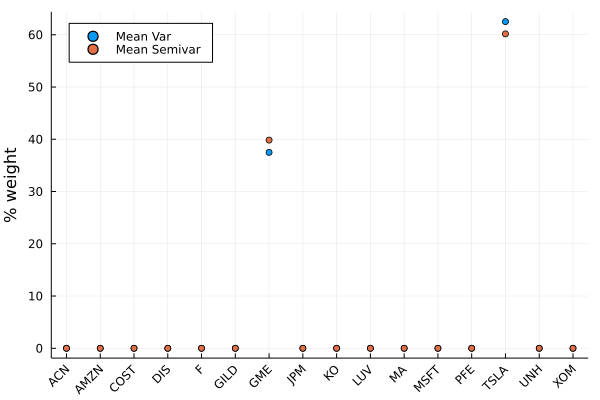

In [52]:
fig = plot()
scatter!(fig, 1:length(emv.tickers), emv.weights*100, label = "Mean Var")
scatter!(fig, 1:length(emv.tickers), emsv.weights*100, label = "Mean Semivar")
plot(fig, ylabel="% weight", xticks=(1:length(emv.tickers), emv.tickers), xrotation=45, legend=:topleft)

Unfortunately this only gave two assets meaningful weights, this makes the portfolio vulnerable to fluctuations, so lets add a bit of L2 regularisation. L2 reg tends to be more powerful than increasing the risk aversion, but both are viable strategies.

In [53]:
emv = EffMeanVar(tickers, mean_ret, S, extra_obj_terms = (quote L2_reg(model[:w], 0.5) end,))
emsv = EffMeanSemivar(tickers, mean_ret, Matrix(returns), extra_obj_terms = (quote L2_reg(model[:w], 0.5) end,))

max_utility!(emv)
max_utility!(emsv)

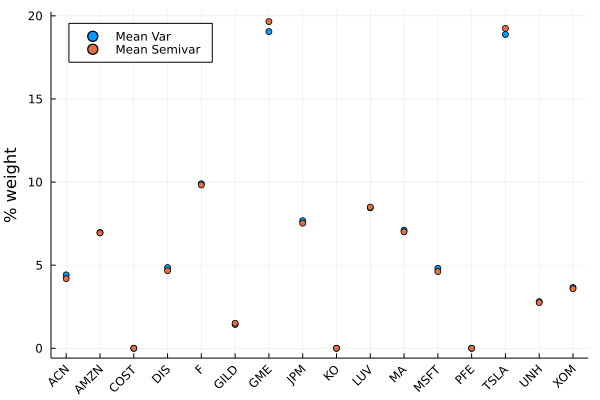

In [54]:
fig = plot()
scatter!(fig, 1:length(emv.tickers), emv.weights*100, label = "Mean Var")
scatter!(fig, 1:length(emv.tickers), emsv.weights*100, label = "Mean Semivar")
plot(fig, ylabel="% weight", xticks=(1:length(emv.tickers), emv.tickers), xrotation=45, legend=:topleft)

In [55]:
println("Mean variance with semicovariance.")
mu_u1, sigma_u1, sr_u1 = portfolio_performance(emv, verbose=true)
println((mu_u1, sigma_u1, sr_u1))

println("\nMean semivariance optimisation.")
mu_u2, sigma_u2, sr_u2 = portfolio_performance(emsv, verbose=true)
println((mu_u2, sigma_u2, sr_u2))

Mean variance with semicovariance.
LOCALLY_SOLVED
Expected annual return: 34.48 %
Annual volatility: 20.93 %
Sharpe Ratio: 1.552
(0.34484078570552557, 0.20932337761199013, 1.5518609980948375)

Mean semivariance optimisation.
LOCALLY_SOLVED
Expected annual return: 34.66 %
Annual semi-deviation: 18.65 %
Sortino Ratio: 1.751
(0.34655642057511915, 0.1865182974528883, 1.7508009939754159)


Lets instead increase the risk aversion to see what it does.

In [56]:
emv = EffMeanVar(tickers, mean_ret, S)
emsv = EffMeanSemivar(tickers, mean_ret, Matrix(returns))

max_utility!(emv, 8)
max_utility!(emsv, 8)

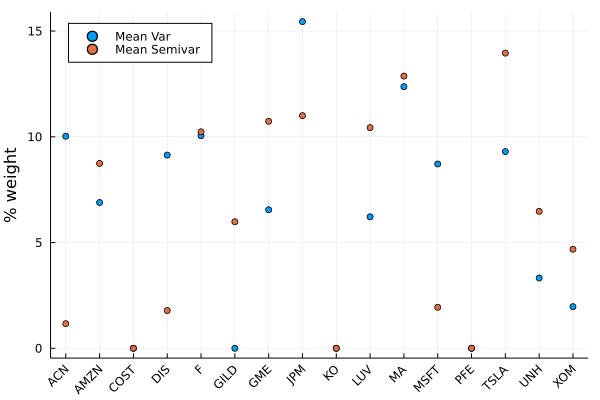

In [57]:
fig = plot()
scatter!(fig, 1:length(emv.tickers), emv.weights*100, label = "Mean Var")
scatter!(fig, 1:length(emv.tickers), emsv.weights*100, label = "Mean Semivar")
plot(fig, ylabel="% weight", xticks=(1:length(emv.tickers), emv.tickers), xrotation=45, legend=:topleft)

In [58]:
println("Mean variance with semicovariance.")
mu_u1, sigma_u1, sr_u1 = portfolio_performance(emv, verbose=true)
println((mu_u1, sigma_u1, sr_u1))

println("\nMean semivariance optimisation.")
mu_u2, sigma_u2, sr_u2 = portfolio_performance(emsv, verbose=true)
println((mu_u2, sigma_u2, sr_u2))

Mean variance with semicovariance.
LOCALLY_SOLVED
Expected annual return: 30.7 %
Annual volatility: 17.15 %
Sharpe Ratio: 1.673
(0.30695432283383384, 0.17152214395560336, 1.6729870337214816)

Mean semivariance optimisation.
LOCALLY_SOLVED
Expected annual return: 32.15 %
Annual semi-deviation: 16.14 %
Sortino Ratio: 1.868
(0.3215136020033851, 0.16141025060407285, 1.8679953774619626)


As you can see, L2 regularisation is quite a bit more powerful than increasing the risk aversion. Both are viable strategies and I would switch it up between strategies when regularly investing. Having multiple varied portfolios across time and markets is a good way of hedging against systemic risk.

Next we'll show the efficient return. We'll use a multiple of the return given by the minimum risk optimisation of the mean semivariance optimiser. 

Change the value to `mu1` and `mu2` and compare to the minimum risk optimisations. What happens if you lower the values to below those given by `min_risk!`?

In [59]:
efficient_return!(emv, 1.5*mu2)# mu1
efficient_return!(emsv, 1.5*mu2)# mu2

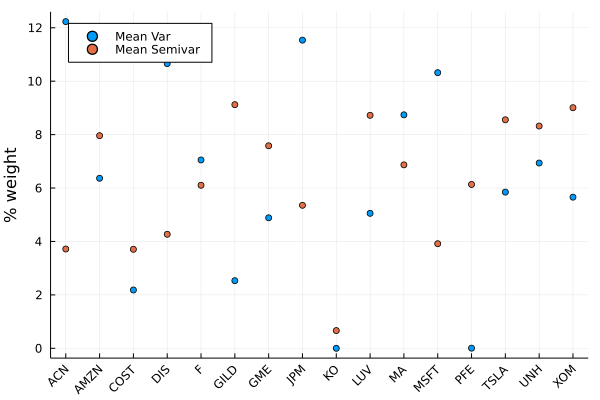

In [60]:
fig = plot()
scatter!(fig, 1:length(emv.tickers), emv.weights*100, label = "Mean Var")
scatter!(fig, 1:length(emv.tickers), emsv.weights*100, label = "Mean Semivar")
plot(fig, ylabel="% weight", xticks=(1:length(emv.tickers), emv.tickers), xrotation=45, legend=:topleft)

In [61]:
println("Mean variance with semicovariance.")
mu_er1, sigma_er1, sr_er1 = portfolio_performance(emv, verbose=true)
println((mu_er1, sigma_er1, sr_er1))

println("\nMean semivariance optimisation.")
mu_er2, sigma_er2, sr_er2 = portfolio_performance(emsv, verbose=true)
println((mu_er2, sigma_er2, sr_er2))

Mean variance with semicovariance.
LOCALLY_SOLVED
Expected annual return: 28.9 %
Annual volatility: 15.94 %
Sharpe Ratio: 1.688
(0.28899744617762224, 0.15937957476777495, 1.6877786665547747)

Mean semivariance optimisation.
LOCALLY_SOLVED
Expected annual return: 28.9 %
Annual semi-deviation: 13.96 %
Sortino Ratio: 1.927
(0.28899743923419347, 0.1395752805228569, 1.9272570202009542)


Next we have the efficient risk optimisation. We'll also use the risk from the minimum risk optimisation as the benchmark. Change it to see what happens. If you go lower than the minimum Ipopt will complain but solve it as best it can. Other optimisers might not do this, so it's always worth checking if the solution is useful.

In [62]:
efficient_risk!(emv, 1.5*sigma2)
efficient_risk!(emsv, 1.5*sigma2)

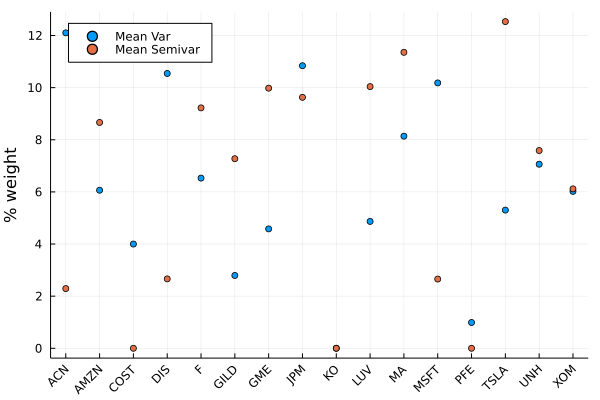

In [63]:
fig = plot()
scatter!(fig, 1:length(emv.tickers), emv.weights*100, label = "Mean Var")
scatter!(fig, 1:length(emv.tickers), emsv.weights*100, label = "Mean Semivar")
plot(fig, ylabel="% weight", xticks=(1:length(emv.tickers), emv.tickers), xrotation=45, legend=:topleft)

In [64]:
println("Mean variance with semicovariance.")
mu_es1, sigma_es1, sr_es1 = portfolio_performance(emv, verbose=true)
println((mu_es1, sigma_es1, sr_es1))

println("\nMean semivariance optimisation.")
mu_es2, sigma_es2, sr_es2 = portfolio_performance(emsv, verbose=true)
println((mu_es2, sigma_es2, sr_es2))

Mean variance with semicovariance.
LOCALLY_SOLVED
Expected annual return: 28.43 %
Annual volatility: 15.65 %
Sharpe Ratio: 1.689
(0.2843274050782452, 0.15646543583687028, 1.6893661124865367)

Mean semivariance optimisation.
LOCALLY_SOLVED
Expected annual return: 31.49 %
Annual semi-deviation: 15.65 %
Sortino Ratio: 1.885
(0.31494132867752833, 0.15646540516785185, 1.8850258199959489)

We also have the built-in max sharpe optimisation, which uses the same variable transformation. Remember that for these we have to regenerate the optimiser structures to ensure we don't pollute the variable transformation. Again we have to remember that we're using CAPM returns, which already account for the risk free rate.

In [65]:
emv = EffMeanVar(tickers, mean_ret, S, rf=eps())
emsv = EffMeanSemivar(tickers, mean_ret, Matrix(returns), rf=eps())

max_sharpe!(emv)
max_sharpe!(emsv)

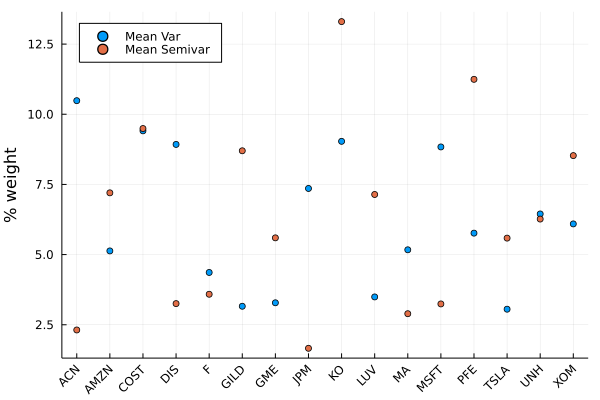

In [66]:
fig = plot()
scatter!(fig, 1:length(emv.tickers), emv.weights*100, label = "Mean Var")
scatter!(fig, 1:length(emv.tickers), emsv.weights*100, label = "Mean Semivar")
plot(fig, ylabel="% weight", xticks=(1:length(emv.tickers), emv.tickers), xrotation=45, legend=:topleft)

In [67]:
println("Mean variance with semicovariance.")
mu_sr1, sigma_sr1, sr_sr1 = portfolio_performance(emv, verbose=true)
println((mu_sr1, sigma_sr1, sr_sr1))

println("\nMean semivariance optimisation.")
mu_sr2, sigma_sr2, sr_sr2 = portfolio_performance(emsv, verbose=true)
println((mu_sr2, sigma_sr2, sr_sr2))

Mean variance with semicovariance.
LOCALLY_SOLVED
Expected annual return: 25.82 %
Annual volatility: 14.12 %
Sharpe Ratio: 1.828
(0.2582413290160766, 0.14124900814215957, 1.828270034690582)

Mean semivariance optimisation.
LOCALLY_SOLVED
Expected annual return: 25.67 %
Annual semi-deviation: 12.22 %
Sortino Ratio: 2.101
(0.25666428526865215, 0.12218247685791345, 2.100663629262713)


We can use the nonlinear optimiser for this just like we did in the previous section. 

We could do the same for the risk measure used in `EffMeanSemivar`, but it takes an age and a half to optimise. So if you need a nonlinear optimisation for mean semivariance, you're better off using `EffMeanVar` and giving it a semicovariance.

In [68]:
nl_emv = EffMeanVar(tickers, mean_ret, S, rf=eps())
# These correspond to obj_params in the demvinition of sharpe_ratio_nl. 
obj_params = [nl_emv.mean_ret, nl_emv.cov_mtx, nl_emv.rf, 0]
# # This should give an answer close to the max_sharpe! optimisation as γ is zero.
custom_nloptimiser!(nl_emv, sharpe_ratio_nl, obj_params)

nl_mu0, nl_sigma0, nl_sr0 = portfolio_performance(nl_emv, verbose=true)

LOCALLY_SOLVED
Expected annual return: 25.82 %
Annual volatility: 14.12 %
Sharpe Ratio: 1.828


(0.2582413534259684, 0.1412490214935085, 1.8282700346907281)

We can see that the weights are pretty much the same as for the `max_sharpe!` optimisation of the `EffMeanVar` structure when we provide the semicovariance. Not truly optimal in this space, but if you need extra objective terms on the function it's the only way to ensure they will behave properly. Just remember to add the extra terms to the definition of the nonlinear function.

In [69]:
[tickers nl_emv.weights emv.weights emsv.weights]

16×4 Matrix{Any}:
 "ACN"   0.104838   0.104838   0.0231362
 "AMZN"  0.0513067  0.0513067  0.0720028
 "COST"  0.0940928  0.0940928  0.0949121
 "DIS"   0.0892518  0.0892517  0.0325284
 "F"     0.0436284  0.0436283  0.0358629
 "GILD"  0.0315861  0.0315864  0.0869841
 "GME"   0.0328213  0.0328213  0.0559619
 "JPM"   0.0735616  0.0735615  0.0166109
 "KO"    0.0903558  0.0903559  0.133012
 "LUV"   0.0349128  0.0349129  0.071413
 "MA"    0.0517029  0.0517029  0.0289288
 "MSFT"  0.0883568  0.0883567  0.0324172
 "PFE"   0.057638   0.057638   0.112443
 "TSLA"  0.0305377  0.0305377  0.0558647
 "UNH"   0.0644782  0.0644782  0.0626538
 "XOM"   0.060931   0.060931   0.0852684

In theory, the following two cells properly optimise for the mean semivariance non-linearly. However, it takes such a long time that I've commented them out and you should not even try them. For the semivariance optimisation we have a different risk measure, so we have to make a special function for it too. 

Execute at your own peril. I gave up after 10 minutes. Alternatively, go to the final example in [Conditional Value at Risk](#conditional-value-at-risk), for a way to add solver-specific attributes to limit execution time.

In [70]:
#=
function sortino_ratio(w::T...) where {T}
    mean_ret = obj_params[1]
    rf = obj_params[2]
    freq = obj_params[3]
    num_tickers = obj_params[4]

    weights = w[1:num_tickers]
    n = w[num_tickers+1:end]

    mu = PortfolioOptimiser.port_return(weights, mean_ret) - rf
    sigma = dot(n, n) * freq

    return -mu/sigma
end
=#

In [71]:
#=
nl_emsv = EffMeanSemivar(tickers, mean_ret, Matrix(returns), rf=eps())

obj_params = [nl_emsv.mean_ret, nl_emsv.rf, nl_emsv.freq, length(tickers)]
custom_nloptimiser!(nl_emsv, sortino_ratio, obj_params, [(nl_emsv.model[:n], 1 / length(nl_emsv.model[:n]))])

portfolio_performance(nl_emsv, verbose=true)
[tickers nl_emsv.weights]
=#

The reason why the `EffMeanSemivar` struct is truly optimum in mean-semivariance space is because it takes into account all historical entries, whereas the covariance is a summary of the overall behaviour. The `EffMeanSemivar` generates a constraint on the portfolio returns (adjusted to the target for discerning upside and downside returns and number of observations), for each observation.

In [72]:
length(emsv.model[:semi_var])

3021

## Conditional Value at Risk

Conditional value at risk is the average of some percentage of the worst case loss scenarios, see [here](https://www.ise.ufl.edu/uryasev/files/2011/11/VaR_vs_CVaR_INFORMS.pdf), figure 1 does a good job of explaining the difference between VaR and CVaR. `PortfolioOptimiser.jl` defaults to a confidence level of 95 %, this can be changed with the `beta` keyword argument.

We'll use ECAPM returns with a shrunken covariance, there's no reason why you couldn't use a semicovariance.

Note that CVaR can be quite sensitive to weight fluctuations, small changes in the weights can affect the calculated portfolio performance. This becomes evident if you set the risk aversion to 1 in `max_utility!`, and when using `max_sharpe!`.

In [73]:
target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

mean_ret = ret_model(
    ECAPMRet(),
    Matrix(returns),
    # cspan = num_rows,
    # rspan = num_rows,
    cov_type = CustomCov(),
    custom_cov_estimator = method,
);

We can show the effect of the confidence level.

In [74]:
# Average worst 1 %.
cv1 = EffCVaR(tickers, mean_ret, Matrix(returns), beta=0.99)
# Average worst 5 %.
cv2 = EffCVaR(tickers, mean_ret, Matrix(returns), beta=0.95)
# Average worst 10 %.
cv3 = EffCVaR(tickers, mean_ret, Matrix(returns), beta=0.90)
# Average worst 15 %.
cv4 = EffCVaR(tickers, mean_ret, Matrix(returns), beta=0.85);

In [75]:
min_risk!(cv1)
min_risk!(cv2)
min_risk!(cv3)
min_risk!(cv4)

[cv1.weights cv2.weights cv3.weights cv4.weights]

16×4 Matrix{Float64}:
 3.53679e-7  1.19472e-6  1.88855e-6  5.92196e-6
 7.18882e-7  4.89802e-6  0.00658564  0.0205676
 0.228416    0.261625    0.244441    0.231403
 5.67723e-7  1.27477e-6  2.45403e-6  0.000622263
 2.52487e-7  4.63185e-7  7.24373e-7  1.00344e-6
 0.095977    0.087171    0.050293    0.0430528
 0.0426017   0.00645662  0.00871646  0.0106267
 2.35153e-7  4.15594e-7  8.11159e-7  1.29164e-6
 0.332121    0.385212    0.398999    0.389538
 2.77201e-7  6.72333e-7  3.44182e-6  0.010131
 2.49481e-7  5.51842e-7  9.20625e-7  1.51802e-6
 6.06819e-7  1.73558e-6  3.44731e-6  6.4697e-6
 0.280876    0.221772    0.201541    0.178547
 2.54355e-7  7.73945e-7  8.94072e-7  1.12607e-6
 8.29558e-7  0.0216793   0.0521261   0.0644201
 0.0200045   0.016073    0.0372831   0.0510742

In [76]:
println("CVaR at worst 1 % of cases")
mu1, cvar1 = portfolio_performance(cv1, verbose=true)
println("\nCVaR at worst 5 % of cases")
mu2, cvar2 = portfolio_performance(cv2, verbose=true)
println("\nCVaR at worst 10 % of cases")
mu3, cvar3 = portfolio_performance(cv3, verbose=true)
println("\nCVaR at worst 15 % of cases")
mu4, cvar4 = portfolio_performance(cv4, verbose=true);

CVaR at worst 1 % of cases
LOCALLY_SOLVED
Expected annual return: 17.53 %
Conditional Value at Risk: 3.83 %
Sharpe Ratio: 4.057

CVaR at worst 5 % of cases
LOCALLY_SOLVED
Expected annual return: 15.98 %
Conditional Value at Risk: 2.17 %
Sharpe Ratio: 6.449

CVaR at worst 10 % of cases
LOCALLY_SOLVED
Expected annual return: 16.27 %
Conditional Value at Risk: 1.64 %
Sharpe Ratio: 8.69

CVaR at worst 15 % of cases
LOCALLY_SOLVED
Expected annual return: 16.72 %
Conditional Value at Risk: 1.35 %
Sharpe Ratio: 10.878


As you can see, as you drop the confidence level, the value of CVaR decreases. This follows from the fact that the worst 1 % of all losses will be worse by definition than the worst 10 % of all losses. By increasing the value of `beta`, we fixate on minimising the worst losses.

We can see how the portfolios look in comparison to one another.

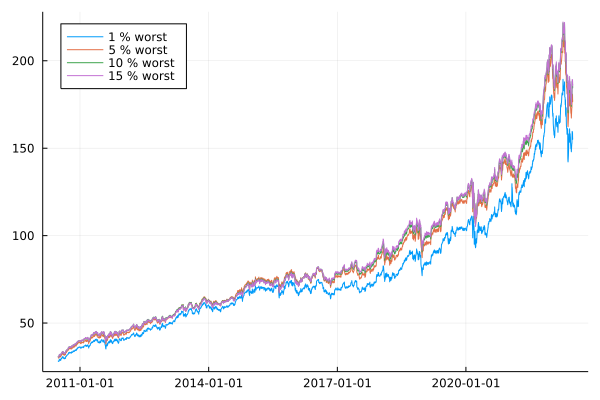

In [77]:
v1 = Matrix(hist_prices[!, tickers]) * cv1.weights
v2 = Matrix(hist_prices[!, tickers]) * cv2.weights
v3 = Matrix(hist_prices[!, tickers]) * cv3.weights
v4 = Matrix(hist_prices[!, tickers]) * cv4.weights

fig = plot()
plot!(fig, hist_prices[!, 1], v1, label="1 % worst")
plot!(fig, hist_prices[!, 1], v2, label="5 % worst")
plot!(fig, hist_prices[!, 1], v3, label="10 % worst")
plot!(fig, hist_prices[!, 1], v4, label="15 % worst")

plot!(fig, legend=:topleft)

As you can see, there are deminishing returns to increasing the value of `beta`.

We also have an optimisation to maximise utility. However, you sometimes have to set the risk aversion to be quite high for it to have an impact. Alternatively, use the L2 regularisation.

In [78]:
max_utility!(cv1, 10)
max_utility!(cv2, 10)
max_utility!(cv3, 10)
max_utility!(cv4, 10)

[cv1.weights cv2.weights cv3.weights cv4.weights]

16×4 Matrix{Float64}:
 1.5201e-7   1.41076e-7  3.69664e-8  1.44059e-8
 0.146034    1.88182e-7  4.78132e-8  1.90169e-8
 9.95682e-8  3.26717e-8  1.29637e-8  5.49599e-9
 3.85512e-7  9.56503e-8  3.29514e-8  1.38448e-8
 0.110763    0.0451527   1.10148e-7  2.65534e-8
 0.114965    7.29989e-8  1.95817e-8  8.23513e-9
 0.130399    0.326063    0.692146    0.821478
 0.226279    0.13938     9.22894e-8  2.32631e-8
 4.44124e-8  2.88953e-8  1.10936e-8  4.69088e-9
 0.0113476   2.2194e-7   5.3718e-8   1.92357e-8
 0.141307    0.288138    9.87545e-8  2.68008e-8
 1.42126e-7  2.0337e-7   4.20929e-8  1.68643e-8
 1.02286e-7  4.48965e-8  1.43305e-8  6.01925e-9
 0.118903    0.201265    0.307853    0.178522
 4.95569e-8  1.08099e-7  3.26113e-8  1.25906e-8
 1.8066e-7   7.52823e-8  2.81793e-8  1.15647e-8

In [79]:
println("CVaR at worst 1 % of cases")
portfolio_performance(cv1, verbose=true)
println("\nCVaR at worst 5 % of cases")
portfolio_performance(cv2, verbose=true)
println("\nCVaR at worst 10 % of cases")
portfolio_performance(cv3, verbose=true)
println("\nCVaR at worst 15 % of cases")
portfolio_performance(cv4, verbose=true);

CVaR at worst 1 % of cases
LOCALLY_SOLVED
Expected annual return: 31.47 %
Conditional Value at Risk: 5.49 %
Sharpe Ratio: 5.369

CVaR at worst 5 % of cases
LOCALLY_SOLVED
Expected annual return: 39.72 %
Conditional Value at Risk: 4.74 %
Sharpe Ratio: 7.956

CVaR at worst 10 % of cases
LOCALLY_SOLVED
Expected annual return: 52.51 %
Conditional Value at Risk: 5.65 %
Sharpe Ratio: 8.945

CVaR at worst 15 % of cases
LOCALLY_SOLVED
Expected annual return: 54.94 %
Conditional Value at Risk: 5.04 %
Sharpe Ratio: 10.512


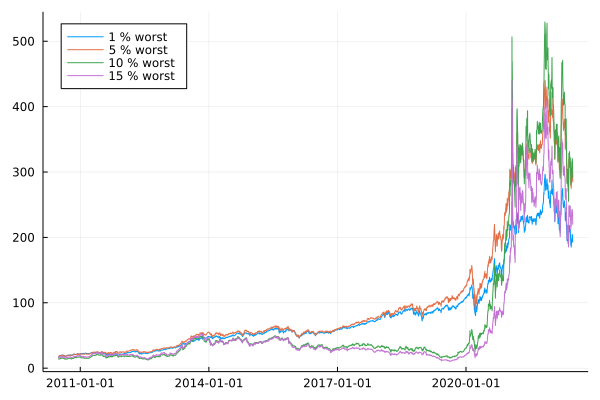

In [80]:
v1 = Matrix(hist_prices[!, tickers]) * cv1.weights
v2 = Matrix(hist_prices[!, tickers]) * cv2.weights
v3 = Matrix(hist_prices[!, tickers]) * cv3.weights
v4 = Matrix(hist_prices[!, tickers]) * cv4.weights

fig = plot()
plot!(fig, hist_prices[!, 1], v1, label="1 % worst")
plot!(fig, hist_prices[!, 1], v2, label="5 % worst")
plot!(fig, hist_prices[!, 1], v3, label="10 % worst")
plot!(fig, hist_prices[!, 1], v4, label="15 % worst")

plot!(fig, legend=:topleft)

You can see how maximising utility may not be the best choice in this case, as it is a lot more volatile, even while being quite risk averse.

Similarly to the other efficient frontier optimisations, we also have `efficient_return!`, `efficient_risk!` and `max_sharpe!`, the same rules apply for them all.

We'll calculate the efficient return for twice the expected return of the minimum CVaR of each portfolio.

In [81]:
efficient_return!(cv1, 2 * mu1)
efficient_return!(cv2, 2 * mu2)
efficient_return!(cv3, 2 * mu3)
efficient_return!(cv4, 2 * mu4)

[cv1.weights cv2.weights cv3.weights cv4.weights]

16×4 Matrix{Float64}:
 3.34813e-7  6.75622e-6  6.65455e-6  1.44488e-5
 0.037638    1.23912e-6  1.26486e-5  1.84978e-5
 1.31733e-7  1.64156e-6  6.71738e-6  2.54991e-6
 5.07609e-7  0.0229958   0.0299266   0.031158
 0.158601    0.0338986   0.054636    0.0499063
 3.10969e-7  0.0833958   0.0248284   0.0207431
 0.168945    0.159859    0.193381    0.212837
 0.19346     0.160955    0.0678084   0.117756
 9.12827e-8  2.93427e-6  1.26834e-5  3.78273e-6
 5.98259e-7  0.00851321  0.0609177   0.0197936
 0.2337      0.239227    0.178331    0.165287
 2.61445e-7  0.0300041   0.0517253   0.10658
 1.16953e-7  0.00732425  0.0151507   5.18167e-6
 0.207653    0.133998    0.114987    0.112934
 1.21878e-7  0.0680245   0.176116    0.140585
 1.96694e-7  0.0517921   0.0321521   0.0223748

In [82]:
println("CVaR at worst 1 % of cases")
portfolio_performance(cv1, verbose=true)
println("\nCVaR at worst 5 % of cases")
portfolio_performance(cv2, verbose=true)
println("\nCVaR at worst 10 % of cases")
portfolio_performance(cv3, verbose=true)
println("\nCVaR at worst 15 % of cases")
portfolio_performance(cv4, verbose=true);

CVaR at worst 1 % of cases
LOCALLY_SOLVED
Expected annual return: 35.06 %
Conditional Value at Risk: 6.42 %
Sharpe Ratio: 5.152

CVaR at worst 5 % of cases
LOCALLY_SOLVED
Expected annual return: 31.96 %
Conditional Value at Risk: 3.52 %
Sharpe Ratio: 8.504

CVaR at worst 10 % of cases
LOCALLY_SOLVED
Expected annual return: 32.55 %
Conditional Value at Risk: 2.73 %
Sharpe Ratio: 11.19

CVaR at worst 15 % of cases
LOCALLY_SOLVED
Expected annual return: 33.44 %
Conditional Value at Risk: 2.34 %
Sharpe Ratio: 13.438


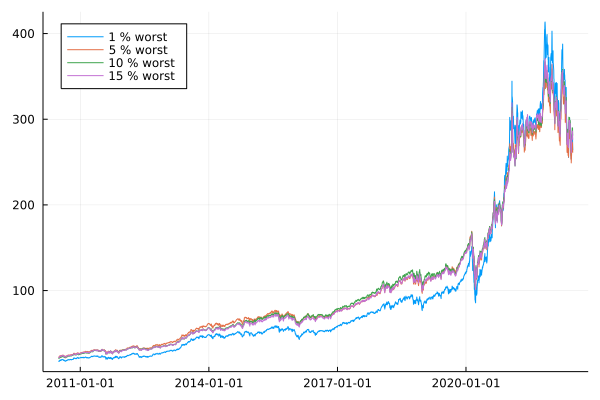

In [83]:
v1 = Matrix(hist_prices[!, tickers]) * cv1.weights
v2 = Matrix(hist_prices[!, tickers]) * cv2.weights
v3 = Matrix(hist_prices[!, tickers]) * cv3.weights
v4 = Matrix(hist_prices[!, tickers]) * cv4.weights

fig = plot()
plot!(fig, hist_prices[!, 1], v1, label="1 % worst")
plot!(fig, hist_prices[!, 1], v2, label="5 % worst")
plot!(fig, hist_prices[!, 1], v3, label="10 % worst")
plot!(fig, hist_prices[!, 1], v4, label="15 % worst")

plot!(fig, legend=:topleft)

We can do the same for the efficient risk.

In [84]:
efficient_risk!(cv1, 2 * cvar1)
efficient_risk!(cv2, 2 * cvar2)
efficient_risk!(cv3, 2 * cvar3)
efficient_risk!(cv4, 2 * cvar4)

[cv1.weights cv2.weights cv3.weights cv4.weights]

16×4 Matrix{Float64}:
 9.08588e-8  2.40217e-7  2.89958e-7  6.23789e-7
 8.01602e-7  3.29612e-7  4.94026e-7  9.3676e-7
 3.12352e-8  5.22162e-8  8.46119e-8  7.89137e-8
 1.37679e-7  1.78872e-7  5.63467e-7  8.42225e-6
 0.0575598   0.0635034   0.0416755   0.0209452
 7.88381e-8  1.54477e-7  4.12849e-7  1.8207e-7
 0.236082    0.265513    0.286244    0.294138
 0.0337146   0.214572    0.140908    0.13656
 1.87094e-8  4.83845e-8  7.12593e-8  7.86671e-8
 2.96874e-7  5.06131e-7  8.11579e-7  0.0150837
 0.331344    0.282996    0.258337    0.216954
 7.50462e-8  4.09743e-6  0.0208451   0.0841976
 2.48495e-8  8.27847e-8  9.91118e-8  1.11699e-7
 0.341297    0.173406    0.168623    0.151484
 3.43205e-8  4.28831e-6  0.0833653   0.0806265
 5.62946e-8  1.3812e-7   2.77063e-7  1.84572e-6

In [85]:
println("CVaR at worst 1 % of cases")
portfolio_performance(cv1, verbose=true)
println("\nCVaR at worst 5 % of cases")
portfolio_performance(cv2, verbose=true)
println("\nCVaR at worst 10 % of cases")
portfolio_performance(cv3, verbose=true)
println("\nCVaR at worst 15 % of cases")
portfolio_performance(cv4, verbose=true);

CVaR at worst 1 % of cases
LOCALLY_SOLVED
Expected annual return: 38.67 %
Conditional Value at Risk: 7.66 %
Sharpe Ratio: 4.79

CVaR at worst 5 % of cases
LOCALLY_SOLVED
Expected annual return: 37.52 %
Conditional Value at Risk: 4.34 %
Sharpe Ratio: 8.193

CVaR at worst 10 % of cases
LOCALLY_SOLVED
Expected annual return: 37.47 %
Conditional Value at Risk: 3.29 %
Sharpe Ratio: 10.798

CVaR at worst 15 % of cases
LOCALLY_SOLVED
Expected annual return: 37.27 %
Conditional Value at Risk: 2.71 %
Sharpe Ratio: 13.033


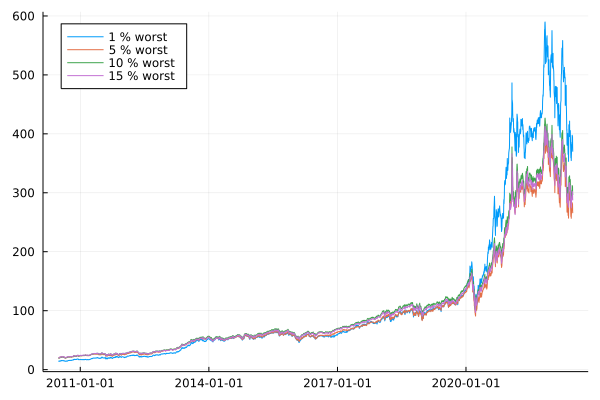

In [86]:
v1 = Matrix(hist_prices[!, tickers]) * cv1.weights
v2 = Matrix(hist_prices[!, tickers]) * cv2.weights
v3 = Matrix(hist_prices[!, tickers]) * cv3.weights
v4 = Matrix(hist_prices[!, tickers]) * cv4.weights

fig = plot()
plot!(fig, hist_prices[!, 1], v1, label="1 % worst")
plot!(fig, hist_prices[!, 1], v2, label="5 % worst")
plot!(fig, hist_prices[!, 1], v3, label="10 % worst")
plot!(fig, hist_prices[!, 1], v4, label="15 % worst")

plot!(fig, legend=:topleft)

We can also optimise for the maximum sharpe ratio. And remember that we have to create fresh instances due to the variable transformation. We'll have a sharpe ratio of zero because we use ECAPM mean returns which already account for it.

In [87]:
# Average worst 1 %.
cv1 = EffCVaR(tickers, mean_ret, Matrix(returns), beta=0.99, rf=0)
# Average worst 5 %.
cv2 = EffCVaR(tickers, mean_ret, Matrix(returns), beta=0.95, rf=0)
# Average worst 10 %.
cv3 = EffCVaR(tickers, mean_ret, Matrix(returns), beta=0.90, rf=0)
# Average worst 15 %.
cv4 = EffCVaR(tickers, mean_ret, Matrix(returns), beta=0.85, rf=0);

In [88]:
max_sharpe!(cv1)
max_sharpe!(cv2)
max_sharpe!(cv3)
max_sharpe!(cv4)

[cv1.weights cv2.weights cv3.weights cv4.weights]

16×4 Matrix{Float64}:
 3.80559e-7  1.59593e-5  2.7961e-6  3.73849e-5
 0.203862    2.39718e-7  0.0163989  0.0142038
 9.36694e-7  0.051785    0.0736989  0.0858372
 6.38673e-7  0.0813144   0.0458966  0.0227515
 0.0730223   0.0244505   0.010724   0.011926
 0.177374    0.0611651   0.044245   0.0285993
 0.115263    0.115423    0.115742   0.106987
 0.204695    0.0511924   0.0492286  0.051204
 1.31206e-7  0.10253     0.130826   0.16026
 0.026833    0.0645618   0.052495   0.0367442
 0.101582    0.0574706   0.0885304  0.116138
 3.33884e-7  0.0527218   0.0229271  0.0815177
 4.67754e-7  0.134229    0.0950751  0.0627958
 0.0973539   0.0812435   0.0643662  0.0505784
 1.18696e-7  0.0643602   0.147034   0.110838
 1.05843e-5  0.0575366   0.0428094  0.059582

In [89]:
println("CVaR at worst 1 % of cases")
portfolio_performance(cv1, verbose=true)
println("\nCVaR at worst 5 % of cases")
portfolio_performance(cv2, verbose=true)
println("\nCVaR at worst 10 % of cases")
portfolio_performance(cv3, verbose=true)
println("\nCVaR at worst 15 % of cases")
portfolio_performance(cv4, verbose=true);

CVaR at worst 1 % of cases
LOCALLY_SOLVED
Expected annual return: 30.01 %
Conditional Value at Risk: 17.39 %
Sharpe Ratio: 1.726

CVaR at worst 5 % of cases
LOCALLY_SOLVED
Expected annual return: 26.52 %
Conditional Value at Risk: 10.85 %
Sharpe Ratio: 2.444

CVaR at worst 10 % of cases
LOCALLY_SOLVED
Expected annual return: 26.03 %
Conditional Value at Risk: 8.2 %
Sharpe Ratio: 3.173

CVaR at worst 15 % of cases
LOCALLY_SOLVED
Expected annual return: 25.59 %
Conditional Value at Risk: 6.73 %
Sharpe Ratio: 3.8


Note how these values are worse than for the other optimisations. This is due to the sensitivity of CVaR to small fluctuations in the asset weights.

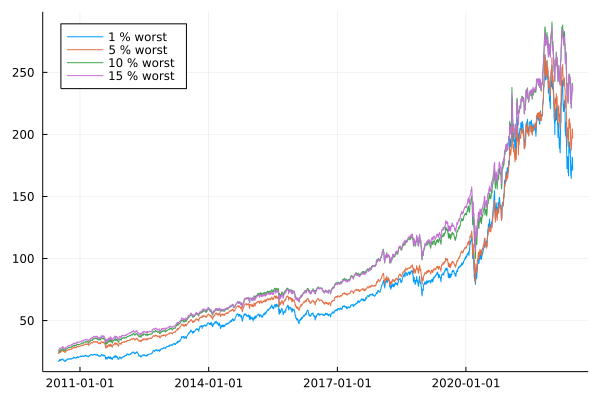

In [90]:
v1 = Matrix(hist_prices[!, tickers]) * cv1.weights
v2 = Matrix(hist_prices[!, tickers]) * cv2.weights
v3 = Matrix(hist_prices[!, tickers]) * cv3.weights
v4 = Matrix(hist_prices[!, tickers]) * cv4.weights

fig = plot()
plot!(fig, hist_prices[!, 1], v1, label="1 % worst")
plot!(fig, hist_prices[!, 1], v2, label="5 % worst")
plot!(fig, hist_prices[!, 1], v3, label="10 % worst")
plot!(fig, hist_prices[!, 1], v4, label="15 % worst")

plot!(fig, legend=:topleft)

We can also use the nonlinear optimiser, but it takes quite long in the notebook, it probably works in a normal Julia session. If computation time is an issue, you can just avoid it or pass optimiser attributes that would limit execution times with the `optimiser_attributes` keyword argument. 

File `tests/EfficientFrontierTests.jl` contains tests the non-linear sharpe ratio optimisation of CVaR vs `max_sharpe!`. The asset weights are equal to a relative tolerance of 1e-3.

The nonlinear function you have to define for CDaR is basically identical to the one used for CVaR, only instead of using `u`, it uses `z`.

Besides, for CVaR and CDaR, the best optimisations are `min_risk!`, `efficient_return!` and `efficient_risk!`.

In [91]:
function cvar_ratio(w...)
    mean_ret = obj_params[1]
    beta = obj_params[2]
    rf = obj_params[3]
    num_tickers = obj_params[4]
    samples = obj_params[5]

    weights = [i for i in w[1:num_tickers]]
    alpha = w[num_tickers+1]
    u = [i for i in w[num_tickers+2:end]]

    mu = PortfolioOptimiser.port_return(weights, mean_ret) - rf
    CVaR = PortfolioOptimiser.cvar(alpha, u, samples, beta)

    return -mu / CVaR
end

cvar_ratio (generic function with 1 method)

In [92]:
cv = EffCVaR(tickers, mean_ret, Matrix(returns), rf=0);

In [93]:
obj_params = [cv.mean_ret, cv.beta, cv.rf, length(cv.tickers), size(cv.returns, 1)]
extra_vars = [(cv.model[:alpha], 0.1), (cv.model[:u], fill(1 / length(cv.model[:u]), length(cv.model[:u])))]
custom_nloptimiser!(cv, cvar_ratio, obj_params, extra_vars, optimiser_attributes = ("max_iter" => 30))

┌ Warning: The optimiser could not solve the problem satisfactorily: ITERATION_LIMIT. The solution may be useful regardless.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\BaseOptimiser\BaseOptimiserUtil.jl:418


## Conditional Drawdown at Risk

The drawdown is the cummulative loss from an all-time high. The critial drawdown is the mean value of all drawdowns past a certain threshold. Each period of drawdown is the period following a new maximum value. The period of drawdown ends when the value reaches its old peak. A new period begins when the value dips below the new peak. Only the drawdowns that cross the threshold are taken into account for the optimisation.

The API is pretty much identical to that of CVaR. Though the optimisations are more computationally expensive.

In [94]:
target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

mean_ret = ret_model(
    ECAPMRet(),
    Matrix(returns),
    # cspan = num_rows,
    # rspan = num_rows,
    cov_type = CustomCov(),
    custom_cov_estimator = method,
);

In [95]:
# Average worst 1 %.
cd1 = EffCDaR(tickers, mean_ret, Matrix(returns), beta=0.99)
# Average worst 5 %.
cd2 = EffCDaR(tickers, mean_ret, Matrix(returns), beta=0.95)
# Average worst 10 %.
cd3 = EffCDaR(tickers, mean_ret, Matrix(returns), beta=0.90)
# Average worst 15 %.
cd4 = EffCDaR(tickers, mean_ret, Matrix(returns), beta=0.85);

In [96]:
min_risk!(cd1)
min_risk!(cd2)
min_risk!(cd3)
min_risk!(cd4)

[cd1.weights cd2.weights cd3.weights cd4.weights]

16×4 Matrix{Float64}:
 4.65059e-8   6.95763e-8  7.97808e-8  8.8569e-8
 2.31382e-7   2.28221e-7  1.0805e-6   1.17841e-6
 0.18839      0.164293    0.106836    0.080731
 2.06173e-8   3.03402e-8  4.68395e-8  6.44725e-8
 7.62379e-9   1.51884e-8  2.40008e-8  3.38968e-8
 0.213512     0.150432    0.119851    0.110869
 0.0371312    3.61138e-7  0.0101962   0.0106047
 3.10707e-8   4.56534e-8  4.96617e-8  5.05693e-8
 0.248365     0.310307    0.289361    0.26447
 4.26517e-8   4.52748e-8  4.87104e-8  6.55641e-8
 0.0365596    0.105383    0.133917    0.170615
 0.155187     0.121622    0.14833     0.147875
 0.0778065    0.109064    0.117408    0.099615
 7.39217e-9   8.66214e-9  1.97744e-8  3.87462e-8
 0.000485216  0.0344844   0.0624523   0.107998
 0.0425634    0.00441379  0.011647    0.00722134

In [97]:
println("CDaR at worst 1 % of cases")
mu1, cdar1 = portfolio_performance(cd1, verbose=true)
println("\nCDaR at worst 5 % of cases")
mu2, cdar2 = portfolio_performance(cd2, verbose=true)
println("\nCDaR at worst 10 % of cases")
mu3, cdar3 = portfolio_performance(cd3, verbose=true)
println("\nCDaR at worst 15 % of cases")
mu4, cdar4 = portfolio_performance(cd4, verbose=true);

CDaR at worst 1 % of cases
LOCALLY_SOLVED
Expected annual return: 19.46 %
Conditional Drawdown at Risk: 13.34 %
Ratio: 1.309

CDaR at worst 5 % of cases
LOCALLY_SOLVED
Expected annual return: 18.08 %
Conditional Drawdown at Risk: 9.65 %
Ratio: 1.666

CDaR at worst 10 % of cases
LOCALLY_SOLVED
Expected annual return: 19.15 %
Conditional Drawdown at Risk: 7.98 %
Ratio: 2.149

CDaR at worst 15 % of cases
LOCALLY_SOLVED
Expected annual return: 19.77 %
Conditional Drawdown at Risk: 6.98 %
Ratio: 2.547


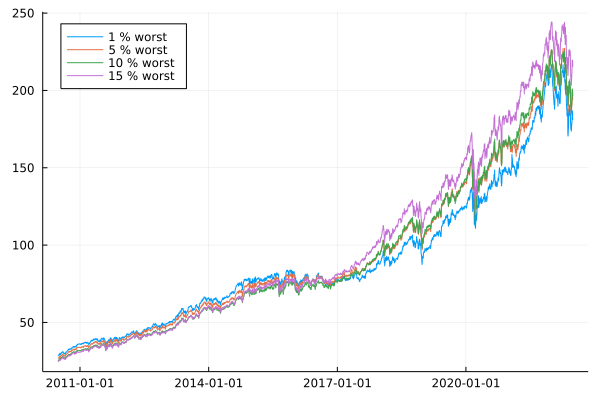

In [98]:
v1 = Matrix(hist_prices[!, tickers]) * cd1.weights
v2 = Matrix(hist_prices[!, tickers]) * cd2.weights
v3 = Matrix(hist_prices[!, tickers]) * cd3.weights
v4 = Matrix(hist_prices[!, tickers]) * cd4.weights

fig = plot()
plot!(fig, hist_prices[!, 1], v1, label="1 % worst")
plot!(fig, hist_prices[!, 1], v2, label="5 % worst")
plot!(fig, hist_prices[!, 1], v3, label="10 % worst")
plot!(fig, hist_prices[!, 1], v4, label="15 % worst")

plot!(fig, legend=:topleft)

Similar to CVaR, there are deminishing returns to using tighter thresholds. But as you can see, the graph is a bit more stable. That's because drawdown takes periods into account rather than specific instances. Drawdowns are ensemble measures rather than point measures like VaR.

We can also optimise the utility, and similar to CVaR, it needs a large risk aversion to have a noticeable effect.

In [99]:
max_utility!(cd1, 10)
max_utility!(cd2, 10)
max_utility!(cd3, 10)
max_utility!(cd4, 10)

[cd1.weights cd2.weights cd3.weights cd4.weights]

16×4 Matrix{Float64}:
 -6.88475e-9   2.19854e-9    6.90675e-9   1.0753e-8
  5.68274e-9   0.00432339    0.0378741    0.0325113
  0.13445      0.0855273     4.97341e-7   0.00864742
 -7.8961e-9   -1.98737e-9    3.08162e-9   8.30545e-9
 -8.39945e-9  -3.91767e-9   -5.72589e-10  7.21422e-10
  0.249275     0.142502      0.123723     0.0934226
  0.0675727    0.0292798     0.0361532    0.0458319
 -7.06853e-9   7.50142e-10   2.69657e-9   5.29651e-9
  0.231299     0.285902      0.27778      0.244634
 -7.46638e-9  -3.79081e-10   5.95654e-9   1.47537e-8
  0.0201804    0.0827629     0.136382     0.171603
  0.183148     0.238688      0.226773     0.21661
  0.00339166   0.038518      0.0181811    0.00473225
 -8.32304e-9  -3.24208e-9    5.54662e-9   8.37261e-8
  0.0843361    0.0597729     0.114227     0.152228
  0.0263466    0.032724      0.0289064    0.0297794

In [100]:
println("CDaR at worst 1 % of cases")
mu1, cdar1 = portfolio_performance(cd1, verbose=true)
println("\nCDaR at worst 5 % of cases")
mu2, cdar2 = portfolio_performance(cd2, verbose=true)
println("\nCDaR at worst 10 % of cases")
mu3, cdar3 = portfolio_performance(cd3, verbose=true)
println("\nCDaR at worst 15 % of cases")
mu4, cdar4 = portfolio_performance(cd4, verbose=true);

CDaR at worst 1 % of cases
LOCALLY_SOLVED
Expected annual return: 21.24 %
Conditional Drawdown at Risk: 13.49 %
Ratio: 1.427

CDaR at worst 5 % of cases
LOCALLY_SOLVED
Expected annual return: 20.32 %
Conditional Drawdown at Risk: 9.87 %
Ratio: 1.855

CDaR at worst 10 % of cases
LOCALLY_SOLVED
Expected annual return: 21.61 %
Conditional Drawdown at Risk: 8.23 %
Ratio: 2.383

CDaR at worst 15 % of cases
LOCALLY_SOLVED
Expected annual return: 22.43 %
Conditional Drawdown at Risk: 7.25 %
Ratio: 2.818


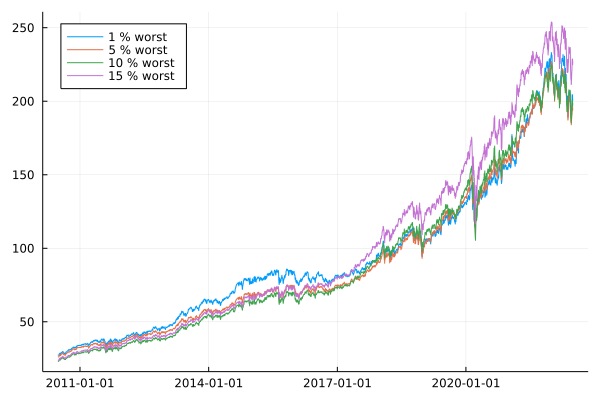

In [101]:
v1 = Matrix(hist_prices[!, tickers]) * cd1.weights
v2 = Matrix(hist_prices[!, tickers]) * cd2.weights
v3 = Matrix(hist_prices[!, tickers]) * cd3.weights
v4 = Matrix(hist_prices[!, tickers]) * cd4.weights

fig = plot()
plot!(fig, hist_prices[!, 1], v1, label="1 % worst")
plot!(fig, hist_prices[!, 1], v2, label="5 % worst")
plot!(fig, hist_prices[!, 1], v3, label="10 % worst")
plot!(fig, hist_prices[!, 1], v4, label="15 % worst")

plot!(fig, legend=:topleft)

It doesn't look too disimilar from the minimum CDaR graph, it may be a little bit smoother. Obviously the higher the risk aversion, the smoother it will look.

We can also optimise for a target return.

In [102]:
efficient_return!(cd1, 2 * mu1)
efficient_return!(cd2, 2 * mu2)
efficient_return!(cd3, 2 * mu3)
efficient_return!(cd4, 2 * mu4)

[cd1.weights cd2.weights cd3.weights cd4.weights]

16×4 Matrix{Float64}:
  1.1485e-9     7.016e-9      7.94943e-9    9.02647e-9
 -8.3679e-10    4.0184e-9     2.39871e-8    0.0212279
 -5.39896e-9   -2.93597e-9   -2.75565e-9   -2.78563e-9
  3.56105e-10   2.80704e-9   -6.30824e-11  -1.19866e-9
  2.66004e-8    3.09309e-8    1.20858e-8    6.07385e-9
 -6.31168e-9   -4.16697e-9   -5.09784e-9   -5.40385e-9
  0.334851      0.368818      0.44895       0.46959
  3.31861e-9    9.23818e-9    8.30444e-9    1.30203e-8
 -6.46694e-9   -4.17188e-9   -4.25959e-9   -4.41866e-9
  9.67037e-10   7.80997e-9    2.05078e-8    5.06785e-8
  0.258691      0.452636      0.368324      0.246641
  2.8142e-9     1.02144e-8    1.95567e-8    3.19118e-8
 -7.13146e-9   -5.10992e-9   -5.33365e-9   -5.25669e-9
  0.406459      0.178546      0.182725      0.262542
 -5.66076e-9   -2.05953e-9   -1.76164e-9    1.20672e-11
 -5.08207e-9   -1.73545e-10  -9.19797e-10  -1.17083e-9

In [103]:
println("CDaR at worst 1 % of cases")
mu1, cdar1 = portfolio_performance(cd1, verbose=true)
println("\nCDaR at worst 5 % of cases")
mu2, cdar2 = portfolio_performance(cd2, verbose=true)
println("\nCDaR at worst 10 % of cases")
mu3, cdar3 = portfolio_performance(cd3, verbose=true)
println("\nCDaR at worst 15 % of cases")
mu4, cdar4 = portfolio_performance(cd4, verbose=true);

CDaR at worst 1 % of cases
LOCALLY_SOLVED
Expected annual return: 42.48 %
Conditional Drawdown at Risk: 49.0 %
Ratio: 0.826

CDaR at worst 5 % of cases
LOCALLY_SOLVED
Expected annual return: 40.63 %
Conditional Drawdown at Risk: 33.28 %
Ratio: 1.161

CDaR at worst 10 % of cases
LOCALLY_SOLVED
Expected annual return: 43.22 %
Conditional Drawdown at Risk: 35.13 %
Ratio: 1.174

CDaR at worst 15 % of cases
LOCALLY_SOLVED
Expected annual return: 44.86 %
Conditional Drawdown at Risk: 35.35 %
Ratio: 1.212


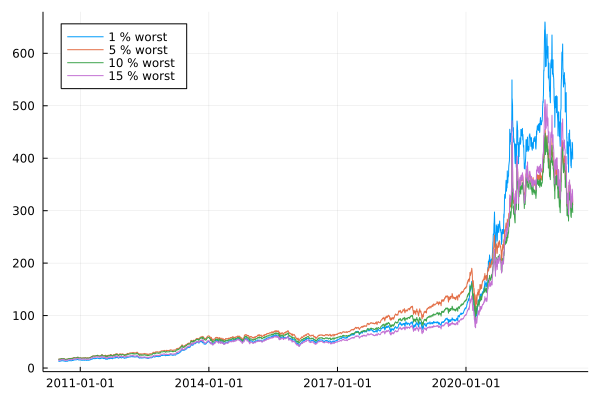

In [104]:
v1 = Matrix(hist_prices[!, tickers]) * cd1.weights
v2 = Matrix(hist_prices[!, tickers]) * cd2.weights
v3 = Matrix(hist_prices[!, tickers]) * cd3.weights
v4 = Matrix(hist_prices[!, tickers]) * cd4.weights

fig = plot()
plot!(fig, hist_prices[!, 1], v1, label="1 % worst")
plot!(fig, hist_prices[!, 1], v2, label="5 % worst")
plot!(fig, hist_prices[!, 1], v3, label="10 % worst")
plot!(fig, hist_prices[!, 1], v4, label="15 % worst")

plot!(fig, legend=:topleft)

As is usual when using target returns, the peaks are quite high.

We can also optimise for a target risk.

In [105]:
efficient_risk!(cd1, 2 * cdar1)
efficient_risk!(cd2, 2 * cdar2)
efficient_risk!(cd3, 2 * cdar3)
efficient_risk!(cd4, 2 * cdar4)

[cd1.weights cd2.weights cd3.weights cd4.weights]

16×4 Matrix{Float64}:
  1.07979e-8    1.15331e-8    8.24146e-9    6.93578e-9
  5.56108e-8    7.33985e-8    4.0728e-8     3.30818e-8
  2.96916e-9    3.40258e-9    2.02653e-9    1.3576e-9
  5.65925e-9    5.92777e-9    3.80987e-9    2.90875e-9
  6.81348e-9    7.31624e-9    4.94371e-9    4.07834e-9
 -5.96653e-10  -4.86891e-10  -1.10528e-9   -1.3881e-9
  0.526565      0.459417      0.567714      0.619778
  1.61774e-8    1.81858e-8    1.36013e-8    1.18318e-8
  3.34037e-10   6.40705e-10  -3.11197e-10  -7.02222e-10
  1.49442e-8    1.77202e-8    1.2677e-8     1.11195e-8
  4.00609e-8    5.00767e-8    2.9011e-8     2.29934e-8
  2.25475e-8    2.56492e-8    1.78855e-8    1.49526e-8
  2.45555e-10   7.31529e-10  -1.51352e-10  -5.17767e-10
  0.473435      0.540583      0.432286      0.380222
  7.78198e-9    8.96484e-9    6.83395e-9    6.03664e-9
  2.06841e-9    2.96608e-9    1.5414e-9     1.00141e-9

In [106]:
println("CDaR at worst 1 % of cases")
mu1, cdar1 = portfolio_performance(cd1, verbose=true)
println("\nCDaR at worst 5 % of cases")
mu2, cdar2 = portfolio_performance(cd2, verbose=true)
println("\nCDaR at worst 10 % of cases")
mu3, cdar3 = portfolio_performance(cd3, verbose=true)
println("\nCDaR at worst 15 % of cases")
mu4, cdar4 = portfolio_performance(cd4, verbose=true);

CDaR at worst 1 % of cases
LOCALLY_SOLVED
Expected annual return: 49.4 %
Conditional Drawdown at Risk: 98.0 %
Ratio: 0.484

CDaR at worst 5 % of cases
LOCALLY_SOLVED
Expected annual return: 48.13 %
Conditional Drawdown at Risk: 66.55 %
Ratio: 0.693

CDaR at worst 10 % of cases
LOCALLY_SOLVED
Expected annual return: 50.17 %
Conditional Drawdown at Risk: 70.25 %
Ratio: 0.686

CDaR at worst 15 % of cases
LOCALLY_SOLVED
Expected annual return: 51.15 %
Conditional Drawdown at Risk: 70.7 %
Ratio: 0.695


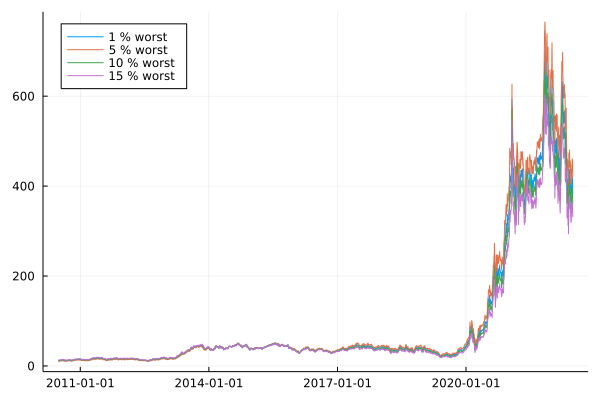

In [107]:
v1 = Matrix(hist_prices[!, tickers]) * cd1.weights
v2 = Matrix(hist_prices[!, tickers]) * cd2.weights
v3 = Matrix(hist_prices[!, tickers]) * cd3.weights
v4 = Matrix(hist_prices[!, tickers]) * cd4.weights

fig = plot()
plot!(fig, hist_prices[!, 1], v1, label="1 % worst")
plot!(fig, hist_prices[!, 1], v2, label="5 % worst")
plot!(fig, hist_prices[!, 1], v3, label="10 % worst")
plot!(fig, hist_prices[!, 1], v4, label="15 % worst")

plot!(fig, legend=:topleft)

Targetting a value of risk also creates more unstable portfolios.

Finally, as with every efficient frontier optimiser, we can optimise for the sharpe ratio using the variable transformation. As with CVaR, small fluctuations in weights have a large effect on the sharpe ratio. Same rules apply as with other max sharpe optimisations.

In [108]:
# Average worst 1 %.
cd1 = EffCDaR(tickers, mean_ret, Matrix(returns), beta=0.99, rf=0)
# Average worst 5 %.
cd2 = EffCDaR(tickers, mean_ret, Matrix(returns), beta=0.95, rf=0)
# Average worst 10 %.
cd3 = EffCDaR(tickers, mean_ret, Matrix(returns), beta=0.90, rf=0)
# Average worst 15 %.
cd4 = EffCDaR(tickers, mean_ret, Matrix(returns), beta=0.85, rf=0);

In [109]:
max_sharpe!(cd1)
max_sharpe!(cd2)
max_sharpe!(cd3)
max_sharpe!(cd4)

[cd1.weights cd2.weights cd3.weights cd4.weights]

16×4 Matrix{Float64}:
 6.53612e-9  1.12956e-8  1.66891e-8  2.14179e-8
 5.59858e-8  3.3471e-8   7.9377e-8   7.5377e-7
 0.0864444   5.13157e-8  1.01202e-7  4.9661e-7
 5.71486e-9  6.52098e-9  1.41932e-8  2.11001e-8
 4.08321e-9  6.15976e-9  8.66945e-9  9.44294e-9
 0.218358    0.131323    0.0897365   0.0767575
 0.0983058   0.073509    0.0655067   0.059435
 1.09131e-8  1.33543e-8  1.4857e-8   1.61471e-8
 0.118831    0.216817    0.189805    0.163226
 9.69619e-9  1.65347e-8  3.31408e-8  3.65846e-8
 1.15633e-7  0.13016     0.194774    0.239274
 0.235263    0.227299    0.214663    0.191639
 1.4624e-8   2.30591e-8  3.53537e-8  4.70496e-8
 1.36736e-8  2.24498e-8  0.00130105  0.0148459
 0.201404    0.181917    0.197551    0.203572
 0.0413933   0.0389738   0.0466625   0.0512492

In [110]:
println("CDaR at worst 1 % of cases")
mu1, cdar1 = portfolio_performance(cd1, verbose=true)
println("\nCDaR at worst 5 % of cases")
mu2, cdar2 = portfolio_performance(cd2, verbose=true)
println("\nCDaR at worst 10 % of cases")
mu3, cdar3 = portfolio_performance(cd3, verbose=true)
println("\nCDaR at worst 15 % of cases")
mu4, cdar4 = portfolio_performance(cd4, verbose=true);

CDaR at worst 1 % of cases
LOCALLY_SOLVED
Expected annual return: 23.45 %
Conditional Drawdown at Risk: 61.31 %
Ratio: 0.383

CDaR at worst 5 % of cases
LOCALLY_SOLVED
Expected annual return: 23.27 %
Conditional Drawdown at Risk: 46.09 %
Ratio: 0.505

CDaR at worst 10 % of cases
LOCALLY_SOLVED
Expected annual return: 23.61 %
Conditional Drawdown at Risk: 37.05 %
Ratio: 0.637

CDaR at worst 15 % of cases
LOCALLY_SOLVED
Expected annual return: 24.03 %
Conditional Drawdown at Risk: 31.87 %
Ratio: 0.754


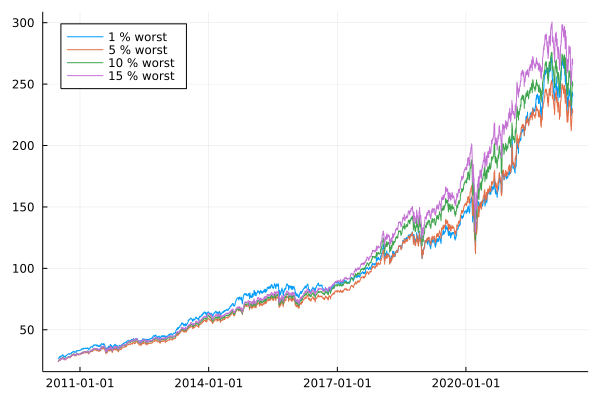

In [111]:
v1 = Matrix(hist_prices[!, tickers]) * cd1.weights
v2 = Matrix(hist_prices[!, tickers]) * cd2.weights
v3 = Matrix(hist_prices[!, tickers]) * cd3.weights
v4 = Matrix(hist_prices[!, tickers]) * cd4.weights

fig = plot()
plot!(fig, hist_prices[!, 1], v1, label="1 % worst")
plot!(fig, hist_prices[!, 1], v2, label="5 % worst")
plot!(fig, hist_prices[!, 1], v3, label="10 % worst")
plot!(fig, hist_prices[!, 1], v4, label="15 % worst")

plot!(fig, legend=:topleft)

We can also use the nonlinear optimiser, but like for CVaR, it takes quite long in the notebook, but probably works in a normal Julia session. If computation time is an issue, you can just avoid it or pass optimiser attributes that would limit execution times with the `optimiser_attributes` keyword argument. 

File `tests/EfficientFrontierTests.jl` contains tests the non-linear sharpe ratio optimisation of CDaR vs `max_sharpe!`. The asset weights are equal to a relative tolerance of 1e-4. 

The nonlinear function you have to define is basically identical to the one used for CVaR, only instead of using `u`, it uses `z`.

Besides, for CVaR and CDaR, the best optimisations are `min_risk!`, `efficient_return!` and `efficient_risk!`.

In [112]:
 function cdar_ratio(w...)
        n = obj_params[1]
        mean_ret = obj_params[2]
        beta = obj_params[3]
        rf = obj_params[4]

        weights = w[1:n]
        alpha = w[n + 1]
        z = w[(n + 2):end]

        samples = length(z)

        ret = PortfolioOptimiser.port_return(weights, mean_ret) - rf
        CDaR = PortfolioOptimiser.cdar(alpha, z, samples, beta)

        return -ret / CDaR
    end

cdar_ratio (generic function with 1 method)

In [113]:
cd1 = EffCDaR(tickers, mean_ret, Matrix(returns), rf=0)
model = cd1.model
alpha = model[:alpha]
z = model[:z]
w = model[:w]
mean_ret = cd1.mean_ret
beta = cd1.beta
rf = cd1.rf

extra_vars = [(alpha, 0.1), (z, 1 / length(z))]
obj_params = [length(w), mean_ret, beta, rf];

In [114]:
custom_nloptimiser!(cd1, cdar_ratio, obj_params, extra_vars, optimiser_attributes = ("max_iter" => 30))

┌ Warning: The optimiser could not solve the problem satisfactorily: ITERATION_LIMIT. The solution may be useful regardless.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\BaseOptimiser\BaseOptimiserUtil.jl:418


In [116]:
println("\nCDaR at worst 5 % of cases")
mu1, cdar1 = portfolio_performance(cd1, verbose=true)


CDaR at worst 5 % of cases
ITERATION_LIMIT
Expected annual return: 29.34 %
Conditional Drawdown at Risk: 28.04 %
Ratio: 1.046


(0.2934307517019934, 0.2804353315329915)

## Asset Allocation

After optimising your portfolio, you have to allocate your assets according to how much money you wish to invest. This is easily done in two ways:

- LP allocation: can only do whole shares but globally minimises the difference in the asset weights between the optimal portfolio vs the one you can afford.
- Greedy allocation: can do fractional shares but may not truly minimise the global difference between the optimal portfolio vs the one you can afford.

In [119]:
cd1 = EffCDaR(tickers, mean_ret, Matrix(returns), beta=0.95)
latest_prices = Vector(hist_prices[end, cd1.tickers]);

In [120]:
min_risk!(cd1)

`Allocation` defaults to an investment of 10,000, but we'll give it 420,000. It's capable of allocating short portfolios, the weights and shares will be negative for those. And you can force a specific short ratio with the keyword argument `short_ratio`. We've made long-only portfolios so this doesn't matter. See the docs for more.

In [129]:
lp_alloc, lp_remaining = Allocation(LP(), cd1, latest_prices; investment=420_000);
println("We have $lp_remaining dollars left.")

[lp_alloc.tickers lp_alloc.shares]

We have 2.7965779999344704 dollars left.


9×2 Matrix{Any}:
 "COST"   147
 "F"        2
 "GILD"  1009
 "KO"    2076
 "MA"     138
 "MSFT"   196
 "PFE"    898
 "UNH"     28
 "XOM"     21

For the greedy allocation, we can pick a rounding value via the `rounding` keyword argument. It defaults to 1, but lets say we can buy half shares.

In [130]:
g_alloc, g_remaining = Allocation(Greedy(), cd1, latest_prices; investment=420_000, rounding=0.5);
println("We have $g_remaining dollars left.")

[g_alloc.tickers g_alloc.shares]

We have 14.211577999988002 dollars left.


9×2 Matrix{Any}:
 "KO"    2076.0
 "COST"   146.5
 "GILD"  1009.0
 "MSFT"   196.0
 "PFE"    898.0
 "MA"     137.5
 "UNH"     28.0
 "XOM"     20.5
 "F"        0.5